# Tristán Del Rosal

# GAN para crear prendas de ropa y accesorios

Usaremos el Dataset "Zalando MNIST" para entrenar la red neuronal antagonica para generar prendas de ropa y accesorios

In [1]:
# Importamos las librerias necesarias
import os
import random
import glob
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Comprobamos si CUDA esta disponible
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("GPU Name:", torch.cuda.get_device_name(0))

CUDA Available: True
CUDA Version: 12.6
GPU Name: NVIDIA GeForce RTX 4080 SUPER


In [3]:
# Cargamos el dataset
from torchvision import datasets, transforms

# Transformación de los datos
# Declaro un transformador que convierte los datos a tensores y los normaliza
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Descarga y carga del dataset
trainset = datasets.FashionMNIST(
    '~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)

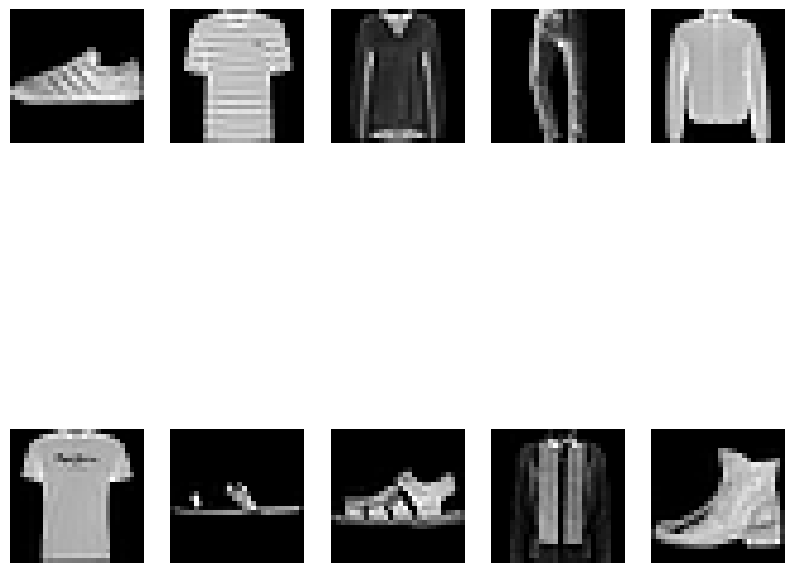

In [4]:
# Muestra las 10 primeras imágenes
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True)
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Función para mostrar imágenes en blanco y negro
def imshow(image, ax=None, normalize=False):
    """Imshow for Tensor."""
    if ax is None:
        _, ax = plt.subplots()
    image = image.numpy().squeeze()

    if normalize:
        mean = np.array([0.5])
        std = np.array([0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image, cmap='gray')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

# Muestra las imágenes
fig, axes = plt.subplots(figsize=(10, 10), ncols=5, nrows=2)
for i in range(10):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    imshow(images[i], ax=ax, normalize=False)
plt.show()


###  Preparación de la GAN

In [5]:
# Extraemos el tensor de entrenamiento
X_train_tensor = trainset.data

In [6]:
# Definimos la arquitectura de la red neuronal
LATENT_DIM = 100

generator = nn.Sequential(
   # Capa densa inicial
   nn.Linear(LATENT_DIM, 7 * 7 * 256, bias=False),
   nn.BatchNorm1d(7 * 7 * 256),
   nn.LeakyReLU(0.2, inplace=True),

   # Redimensión a las dimensiones iniciales
   nn.Unflatten(1, (256, 7, 7)),

   # Primera capa de convolución transpuesta (7x7 -> 14x14)
   nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
   nn.BatchNorm2d(128),
   nn.LeakyReLU(0.2, inplace=True),

   # Segunda capa de convolución transpuesta (14x14 -> 28x28)
   nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
   nn.BatchNorm2d(64),
   nn.LeakyReLU(0.2, inplace=True),
   
   # Tercera capa de convolución transpuesta (28x28 -> 28x28)
   nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False),
   nn.BatchNorm2d(32),
   nn.LeakyReLU(0.2, inplace=True),

   # Capa final de ajuste (28x28)
   nn.Conv2d(32, 1, kernel_size=3, padding=1, bias=False),
   nn.Tanh()
)

# Resumen de la arquitectura del generador
print(generator)

Sequential(
  (0): Linear(in_features=100, out_features=12544, bias=False)
  (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Unflatten(dim=1, unflattened_size=(256, 7, 7))
  (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): LeakyReLU(negative_slope=0.2, inplace=True)
  (7): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): LeakyReLU(negative_slope=0.2, inplace=True)
  (10): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): LeakyReLU(negative_slope=0.2, inplace=True)
  (13): Conv2d(32, 1, kerne

In [7]:
# Dimensiones de cada capa
noise = torch.randn(1, LATENT_DIM)
x = noise
generator.eval()  # Set the generator to evaluation mode
for layer in generator:
    x = layer(x)
    print(f"{x.shape}\t{layer.__class__.__name__}")

torch.Size([1, 12544])	Linear
torch.Size([1, 12544])	BatchNorm1d
torch.Size([1, 12544])	LeakyReLU
torch.Size([1, 256, 7, 7])	Unflatten
torch.Size([1, 128, 14, 14])	ConvTranspose2d
torch.Size([1, 128, 14, 14])	BatchNorm2d
torch.Size([1, 128, 14, 14])	LeakyReLU
torch.Size([1, 64, 28, 28])	ConvTranspose2d
torch.Size([1, 64, 28, 28])	BatchNorm2d
torch.Size([1, 64, 28, 28])	LeakyReLU
torch.Size([1, 32, 28, 28])	ConvTranspose2d
torch.Size([1, 32, 28, 28])	BatchNorm2d
torch.Size([1, 32, 28, 28])	LeakyReLU
torch.Size([1, 1, 28, 28])	Conv2d
torch.Size([1, 1, 28, 28])	Tanh


Las dimensiones de la imagen generada son: torch.Size([1, 1, 28, 28])
El rango de valores de la imagen generada es: [-0.02513309195637703, 0.027231350541114807]


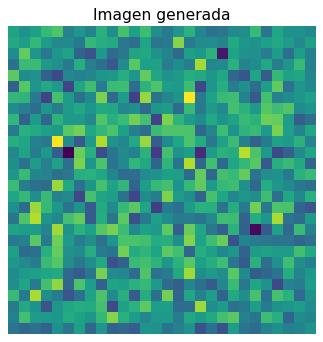

In [8]:
# Comprobamos que el generador funciona correctamente

# Generamos una imagen aleatoria normalizada
noise = torch.randn(1, LATENT_DIM)

# Generamos una imagen a partir del ruido
generated_image = generator(noise)

# Mostramos las dimensiones de la imagen generada
print(f'Las dimensiones de la imagen generada son: {generated_image.shape}')

# Verifica el rango de valores de la imagen generada
print(
    f'El rango de valores de la imagen generada es: [{generated_image.min()}, {generated_image.max()}]')

# Muestra la imagen de generada
# Increased DPI from 40 to 80 for larger image
plt.figure(dpi=80, figsize=(5, 5))
plt.imshow((generated_image.detach().numpy()[0, 0] + 1) / 2)
plt.axis('off')
plt.title('Imagen generada', fontsize=14)  # Increased font size of title
plt.show()

### Definimos el descriminador

In [9]:
discriminator = nn.Sequential(
    # Primera capa de convolución
    nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Dropout(0.3),

    # Segunda capa de convolución
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Dropout(0.3),

    # Capa de aplanado
    nn.Flatten(),

    # Capa final
    nn.Linear(128 * 7 * 7, 1),
    nn.Sigmoid()
)

# Resumen de la arquitectura del discriminador
print(discriminator)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Dropout(p=0.3, inplace=False)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Dropout(p=0.3, inplace=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=6272, out_features=1, bias=True)
  (8): Sigmoid()
)


In [10]:
# Probamos el discriminador con una imagen generada
discriminator.eval()  # Set the discriminator to evaluation mode
decision = discriminator(generated_image)

print(f'La decisión del discriminador es: {decision.item()}')

La decisión del discriminador es: 0.49784916639328003


Es normal que el dicriminador indique incertidumbre porque todavia no hemos entrenado la GAN.

In [11]:
# Inspecciona un lote del dataset
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=100, shuffle=True)
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(f'Dimensiones del lote de imágenes: {images.shape}')
print(f'Rango: de {images.min().item()} a {images.max().item()}')

Dimensiones del lote de imágenes: torch.Size([100, 1, 28, 28])
Rango: de -1.0 a 1.0


In [12]:
# Parámetros del entrenamiento
EPOCHS = 200
LATENT_DIM = 100
BATCH_SIZE = 128
LEARNING_RATE = 0.0002

In [13]:
# Indicamos los optimizadores y las funciones de pérdida
criterion = nn.BCELoss()
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)

In [14]:
# Inicializar los pesos
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        
generator.apply(weights_init)
discriminator.apply(weights_init)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Dropout(p=0.3, inplace=False)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Dropout(p=0.3, inplace=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=6272, out_features=1, bias=True)
  (8): Sigmoid()
)

In [15]:
# Configurar el dispositivo para el entrenamiento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

# Mover los modelos al dispositivo
generator = generator.to(device)
discriminator = discriminator.to(device)

Usando dispositivo: cuda


In [16]:
import torchvision.utils as vutils # Librería para visualización de imágenes

def save_images(fake_images, epoch_label):
    """
    Guarda una cuadrícula de imágenes generadas
    
    Args:
        fake_images (torch.Tensor): Tensor de imágenes generadas
        epoch_label (str): Etiqueta para el nombre del archivo
    """
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(f"Imágenes Generadas - {epoch_label}")
    
    # Hacer un grid con las imágenes
    grid = vutils.make_grid(
        fake_images.cpu().detach(),
        padding=2,
        normalize=True,
        nrow=4
    )
    
    # Convertir de tensor a numpy para mostrar
    plt.imshow(grid.permute(1, 2, 0).numpy(), cmap='gray')
    plt.savefig(f'images/generated_images_{epoch_label}.png')
    plt.close()

Epoch [1/200] D_loss: 0.6825, G_loss: 0.8861


Epoch [2/200] D_loss: 0.6138, G_loss: 1.0638


Epoch [3/200] D_loss: 0.6025, G_loss: 1.1361


Epoch [4/200] D_loss: 0.5772, G_loss: 1.1664


Epoch [5/200] D_loss: 0.5288, G_loss: 1.3558


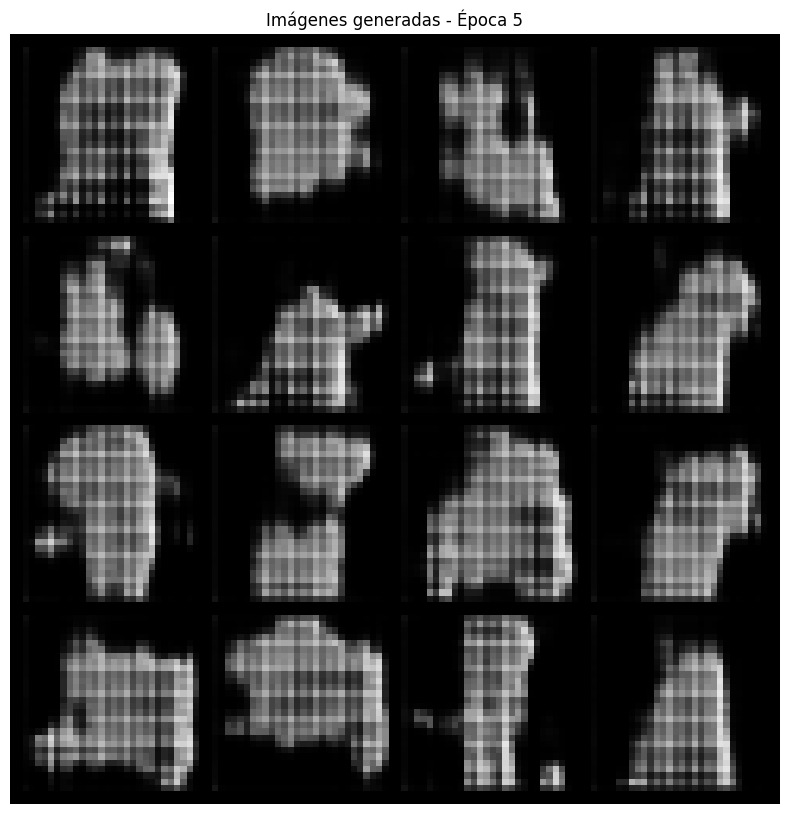

Epoch [6/200] D_loss: 0.4889, G_loss: 1.4665


Epoch [7/200] D_loss: 0.5265, G_loss: 1.5007


Epoch [8/200] D_loss: 0.5329, G_loss: 1.3933


Epoch [9/200] D_loss: 0.5505, G_loss: 1.2977


Epoch [10/200] D_loss: 0.5336, G_loss: 1.3787


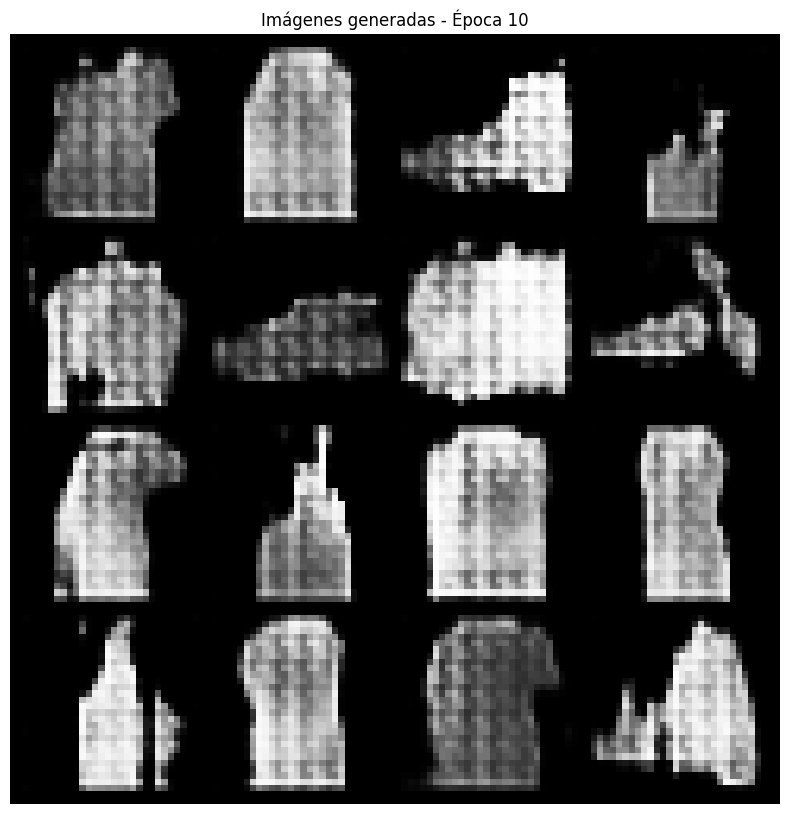

Epoch [11/200] D_loss: 0.5542, G_loss: 1.3379


Epoch [12/200] D_loss: 0.5468, G_loss: 1.3352


Epoch [13/200] D_loss: 0.5614, G_loss: 1.2379


Epoch [14/200] D_loss: 0.5468, G_loss: 1.3440


Epoch [15/200] D_loss: 0.5758, G_loss: 1.2390


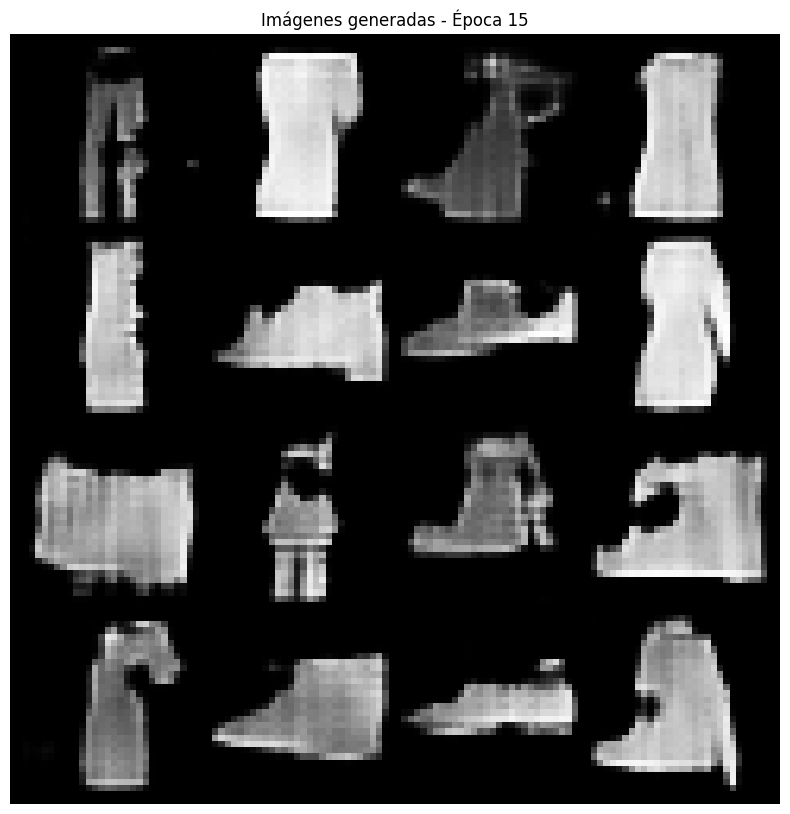

Epoch [16/200] D_loss: 0.5663, G_loss: 1.2198


Epoch [17/200] D_loss: 0.5782, G_loss: 1.1934


Epoch [18/200] D_loss: 0.5948, G_loss: 1.1720


Epoch [19/200] D_loss: 0.5893, G_loss: 1.1666


Epoch [20/200] D_loss: 0.5911, G_loss: 1.1736


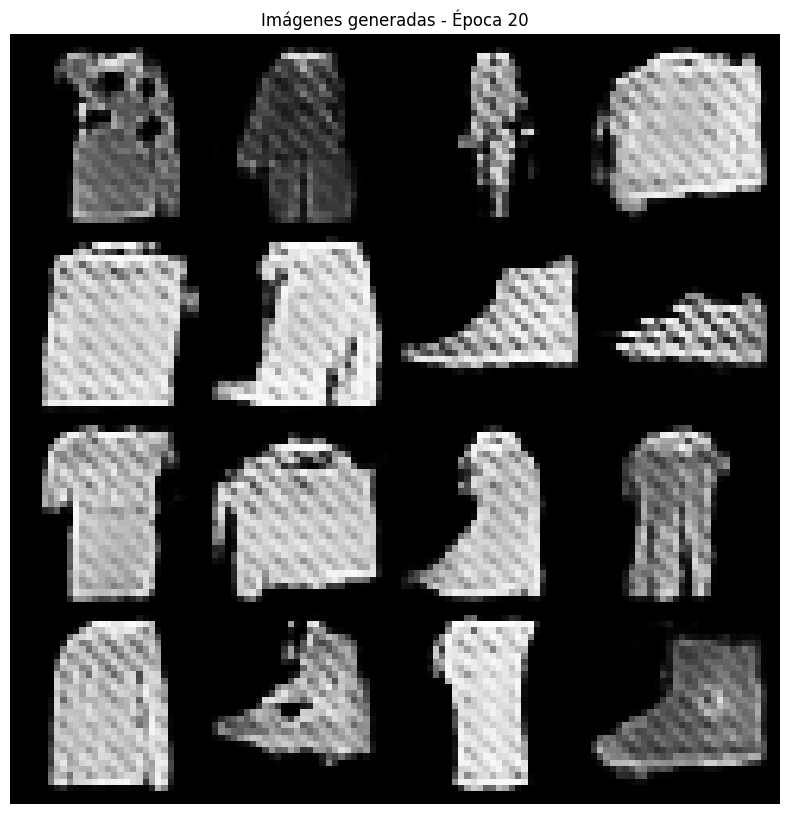

Epoch [21/200] D_loss: 0.5958, G_loss: 1.1152


Epoch [22/200] D_loss: 0.5980, G_loss: 1.0871


Epoch [23/200] D_loss: 0.5989, G_loss: 1.1275


Epoch [24/200] D_loss: 0.5990, G_loss: 1.0991


Epoch [25/200] D_loss: 0.6108, G_loss: 1.0837


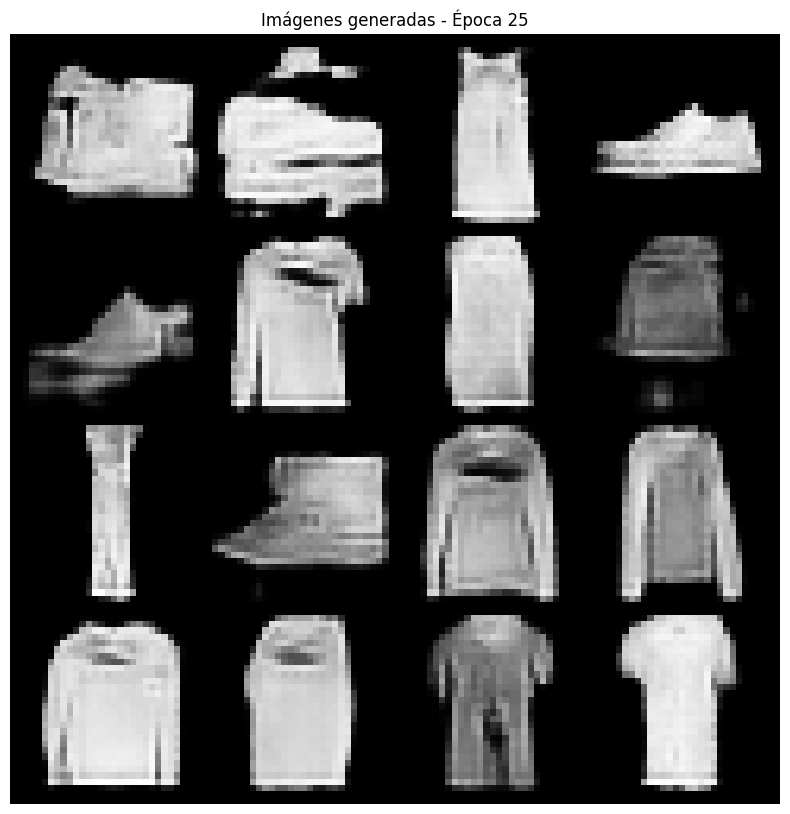

Epoch [26/200] D_loss: 0.6049, G_loss: 1.0862


Epoch [27/200] D_loss: 0.6046, G_loss: 1.0672


Epoch [28/200] D_loss: 0.6118, G_loss: 1.0975


Epoch [29/200] D_loss: 0.6046, G_loss: 1.0593


Epoch [30/200] D_loss: 0.6121, G_loss: 1.0807


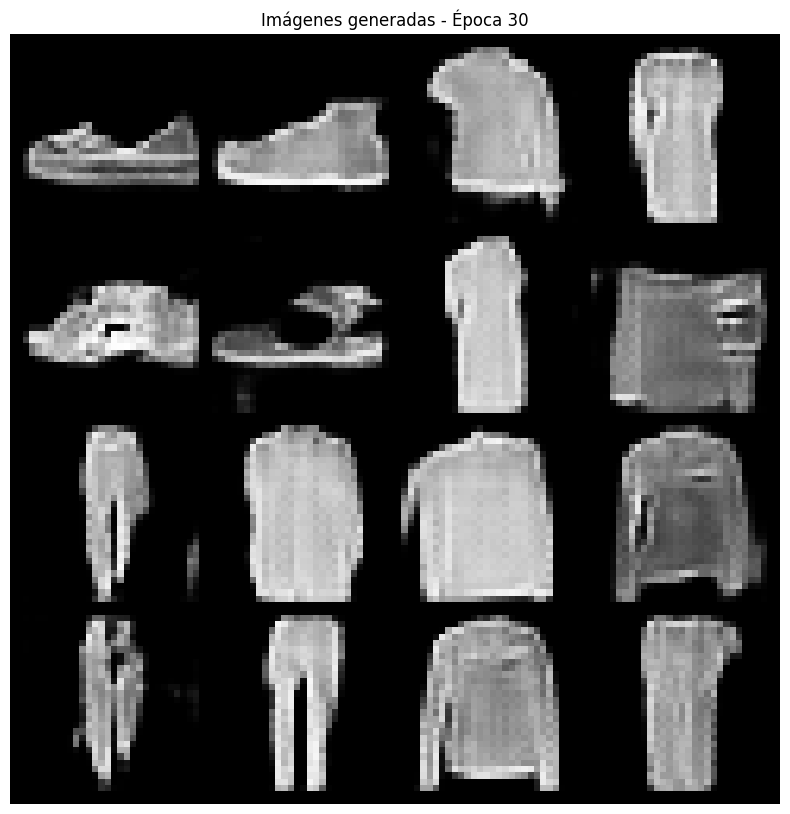

Epoch [31/200] D_loss: 0.6126, G_loss: 1.0578


Epoch [32/200] D_loss: 0.6122, G_loss: 1.0427


Epoch [33/200] D_loss: 0.6203, G_loss: 1.0323


Epoch [34/200] D_loss: 0.6274, G_loss: 1.0270


Epoch [35/200] D_loss: 0.6301, G_loss: 1.0148


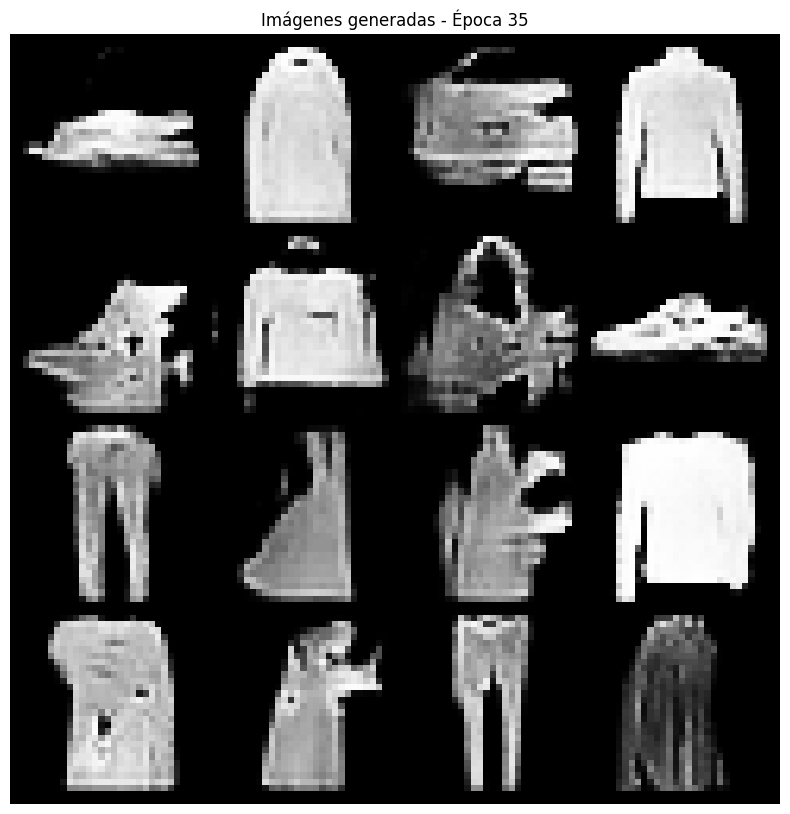

Epoch [36/200] D_loss: 0.6331, G_loss: 1.0022


Epoch [37/200] D_loss: 0.6327, G_loss: 1.0080


Epoch [38/200] D_loss: 0.6404, G_loss: 0.9882


Epoch [39/200] D_loss: 0.6389, G_loss: 0.9803


Epoch [40/200] D_loss: 0.6445, G_loss: 0.9679


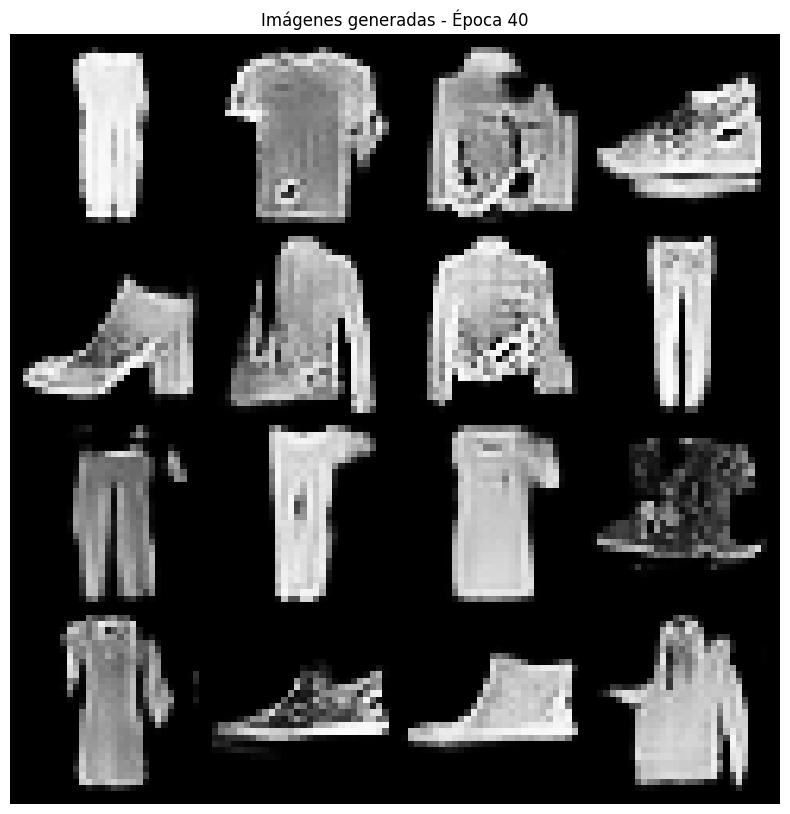

Epoch [41/200] D_loss: 0.6448, G_loss: 0.9489


Epoch [42/200] D_loss: 0.6474, G_loss: 0.9599


Epoch [43/200] D_loss: 0.6441, G_loss: 0.9669


Epoch [44/200] D_loss: 0.6460, G_loss: 0.9511


Epoch [45/200] D_loss: 0.6462, G_loss: 0.9502


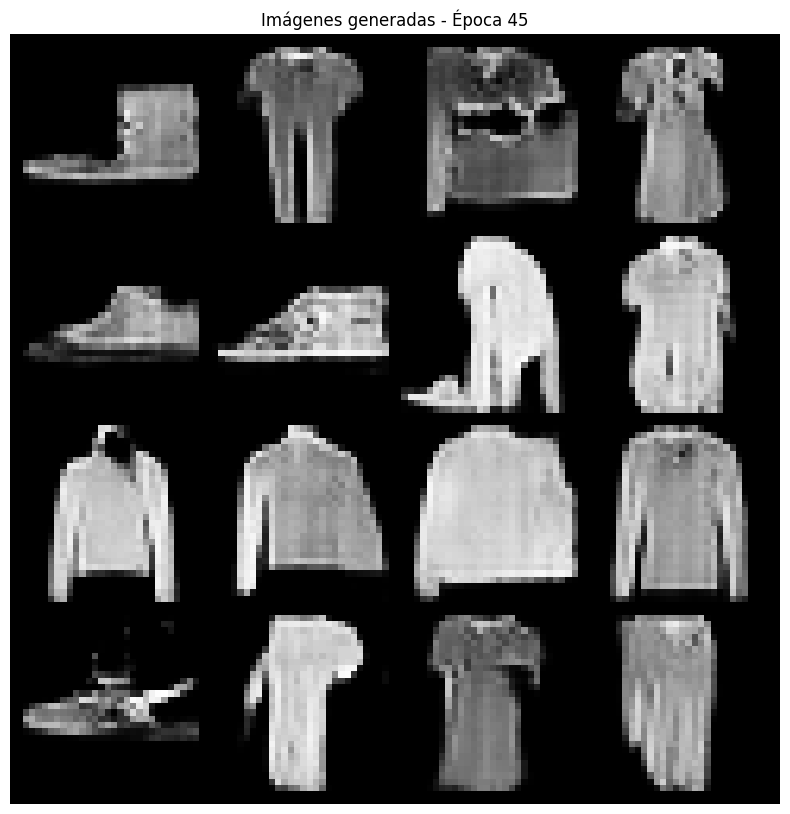

Epoch [46/200] D_loss: 0.6487, G_loss: 0.9398


Epoch [47/200] D_loss: 0.6481, G_loss: 0.9369


Epoch [48/200] D_loss: 0.6513, G_loss: 0.9413


Epoch [49/200] D_loss: 0.6523, G_loss: 0.9269


Epoch [50/200] D_loss: 0.6509, G_loss: 0.9310


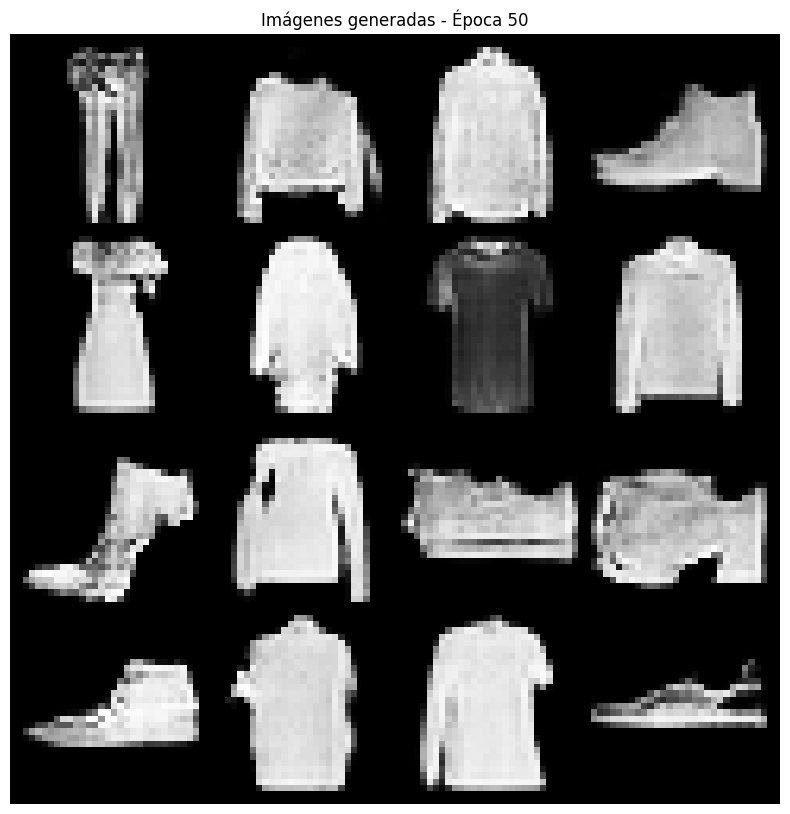

Epoch [51/200] D_loss: 0.6550, G_loss: 0.9265


Epoch [52/200] D_loss: 0.6532, G_loss: 0.9380


Epoch [53/200] D_loss: 0.6541, G_loss: 0.9282


Epoch [54/200] D_loss: 0.6537, G_loss: 0.9194


Epoch [55/200] D_loss: 0.6557, G_loss: 0.9132


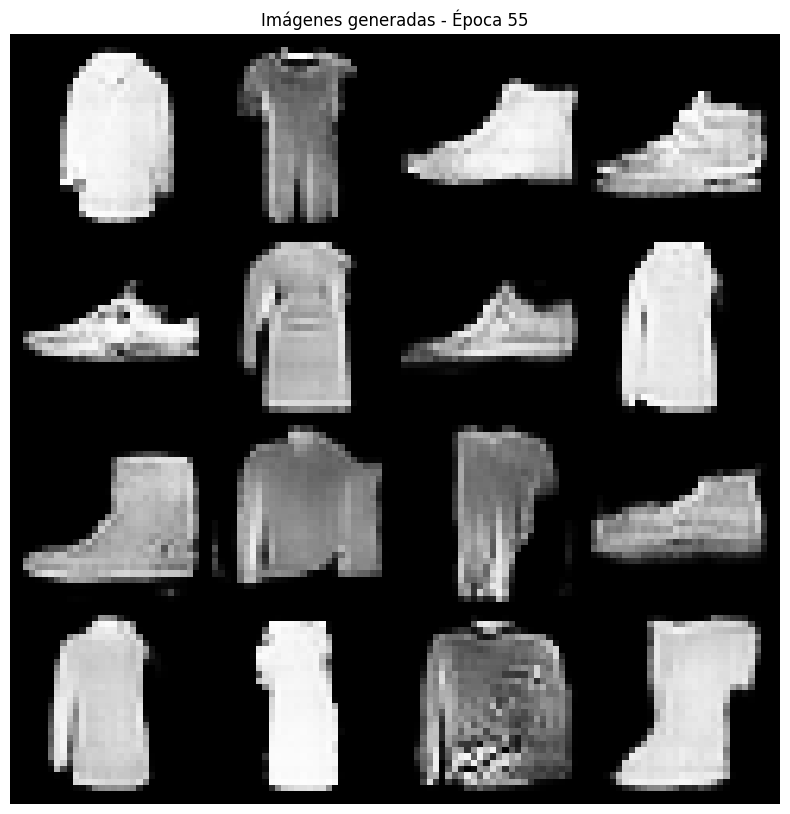

Epoch [56/200] D_loss: 0.6564, G_loss: 0.9151


Epoch [57/200] D_loss: 0.6542, G_loss: 0.9190


Epoch [58/200] D_loss: 0.6568, G_loss: 0.9079


Epoch [59/200] D_loss: 0.6575, G_loss: 0.9181


Epoch [60/200] D_loss: 0.6570, G_loss: 0.9124


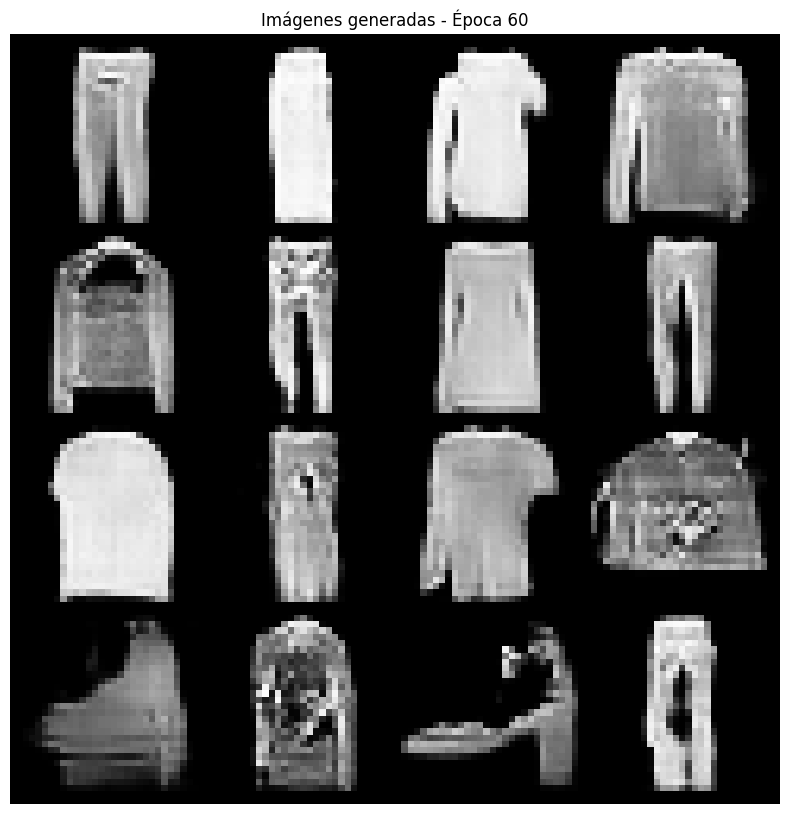

Epoch [61/200] D_loss: 0.6597, G_loss: 0.9040


Epoch [62/200] D_loss: 0.6580, G_loss: 0.9029


Epoch [63/200] D_loss: 0.6576, G_loss: 0.9329


Epoch [64/200] D_loss: 0.6575, G_loss: 0.9085


Epoch [65/200] D_loss: 0.6575, G_loss: 0.8954


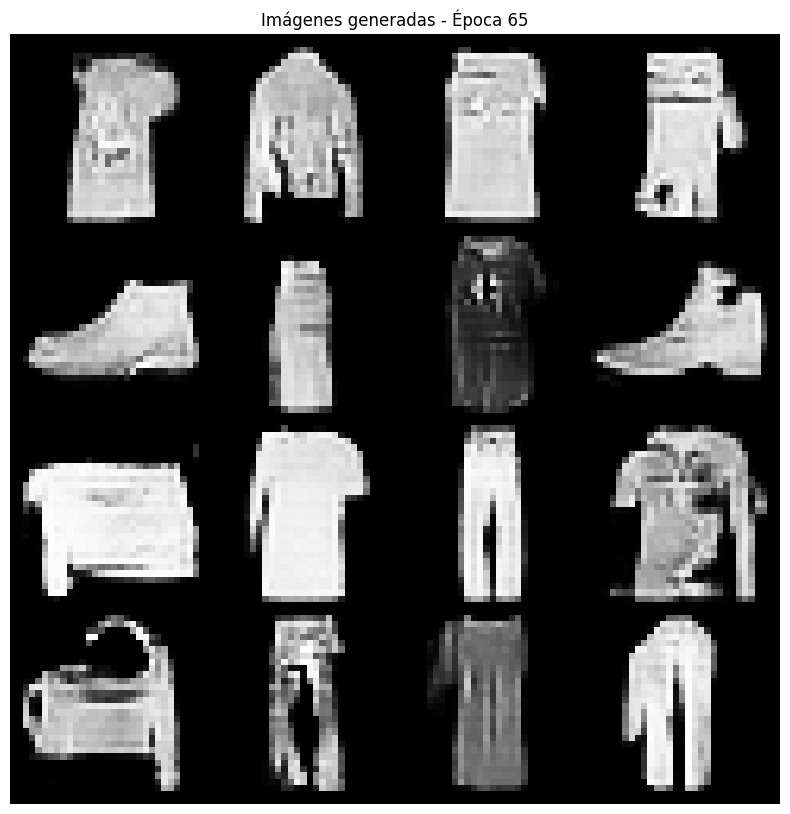

Epoch [66/200] D_loss: 0.6621, G_loss: 0.8924


Epoch [67/200] D_loss: 0.6597, G_loss: 0.8921


Epoch [68/200] D_loss: 0.6598, G_loss: 0.9055


Epoch [69/200] D_loss: 0.6590, G_loss: 0.9025


Epoch [70/200] D_loss: 0.6623, G_loss: 0.8989


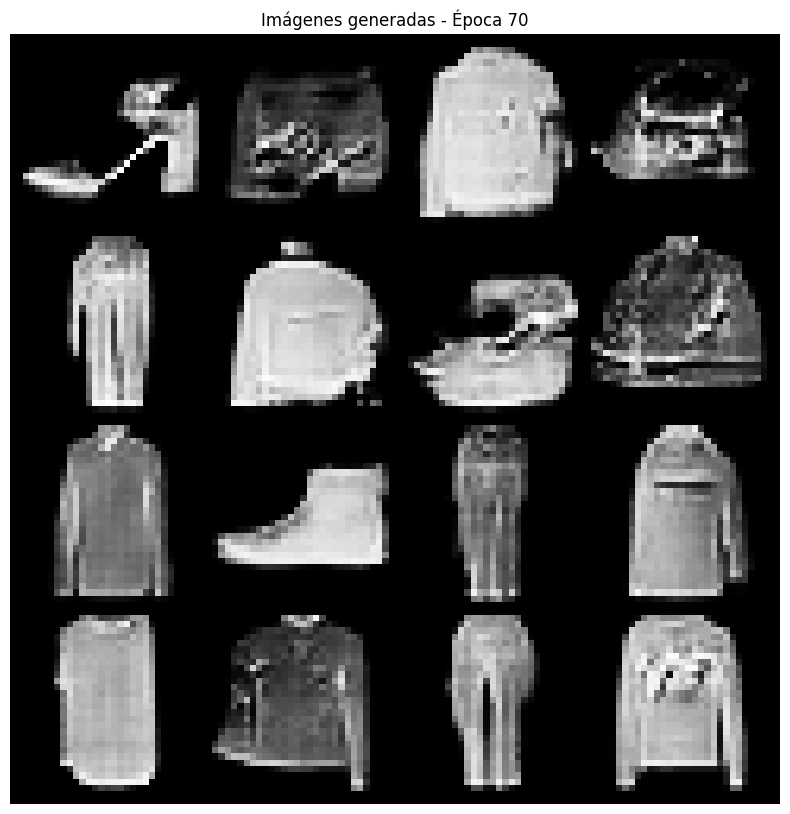

Epoch [71/200] D_loss: 0.6598, G_loss: 0.9007


Epoch [72/200] D_loss: 0.6631, G_loss: 0.8818


Epoch [73/200] D_loss: 0.6595, G_loss: 0.8965


Epoch [74/200] D_loss: 0.6611, G_loss: 0.8996


Epoch [75/200] D_loss: 0.6612, G_loss: 0.8971


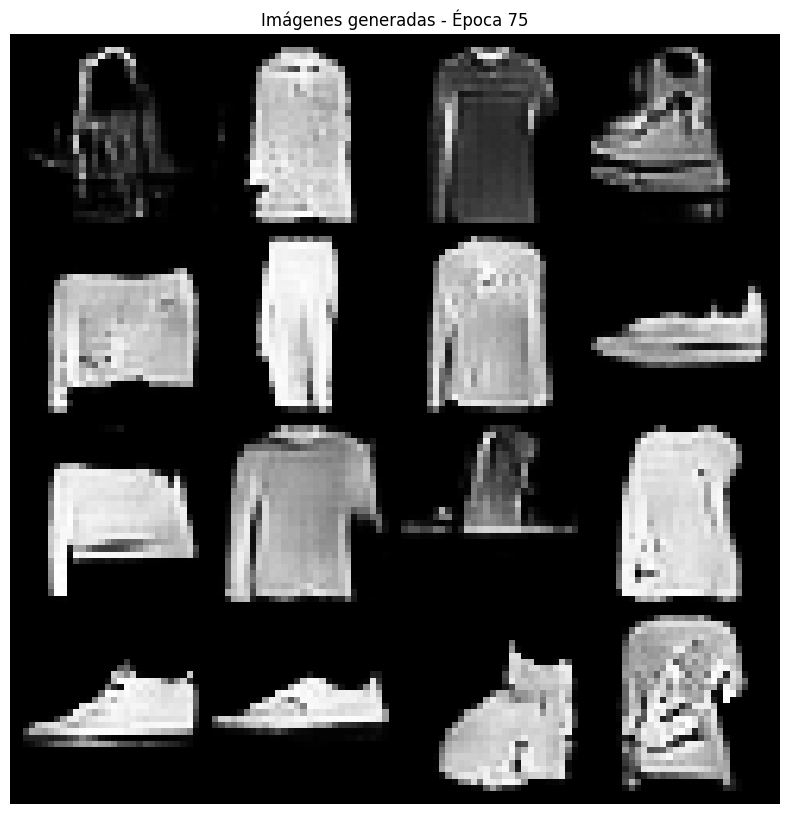

Epoch [76/200] D_loss: 0.6607, G_loss: 0.8843


Epoch [77/200] D_loss: 0.6611, G_loss: 0.8819


Epoch [78/200] D_loss: 0.6611, G_loss: 0.9001


Epoch [79/200] D_loss: 0.6604, G_loss: 0.8943


Epoch [80/200] D_loss: 0.6623, G_loss: 0.8937


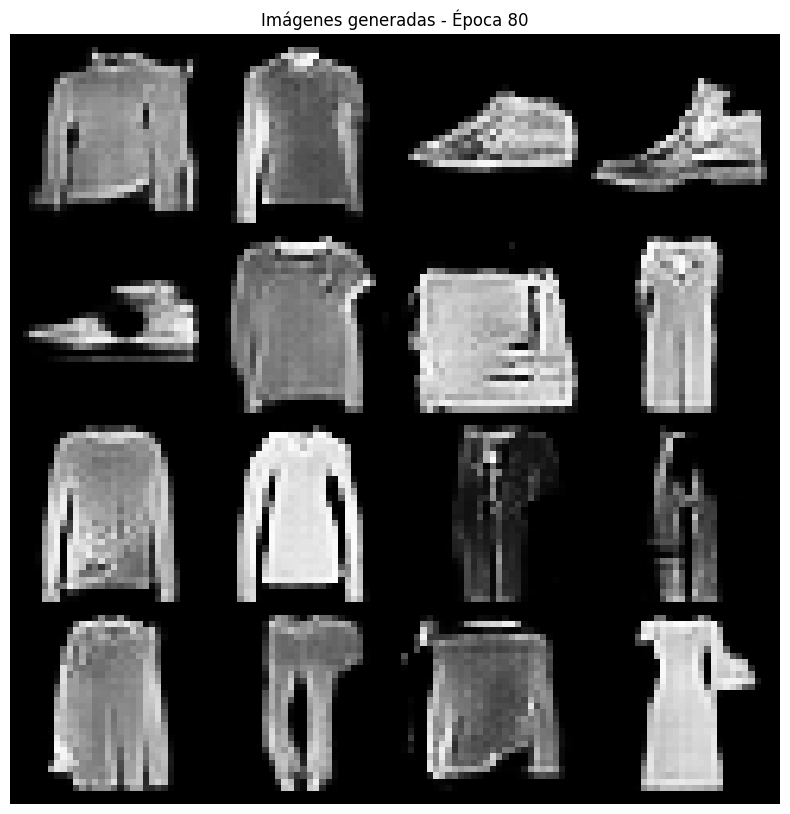

Epoch [81/200] D_loss: 0.6622, G_loss: 0.8796


Epoch [82/200] D_loss: 0.6620, G_loss: 0.8837


Epoch [83/200] D_loss: 0.6633, G_loss: 0.8930


Epoch [84/200] D_loss: 0.6625, G_loss: 0.8885


Epoch [85/200] D_loss: 0.6615, G_loss: 0.8906


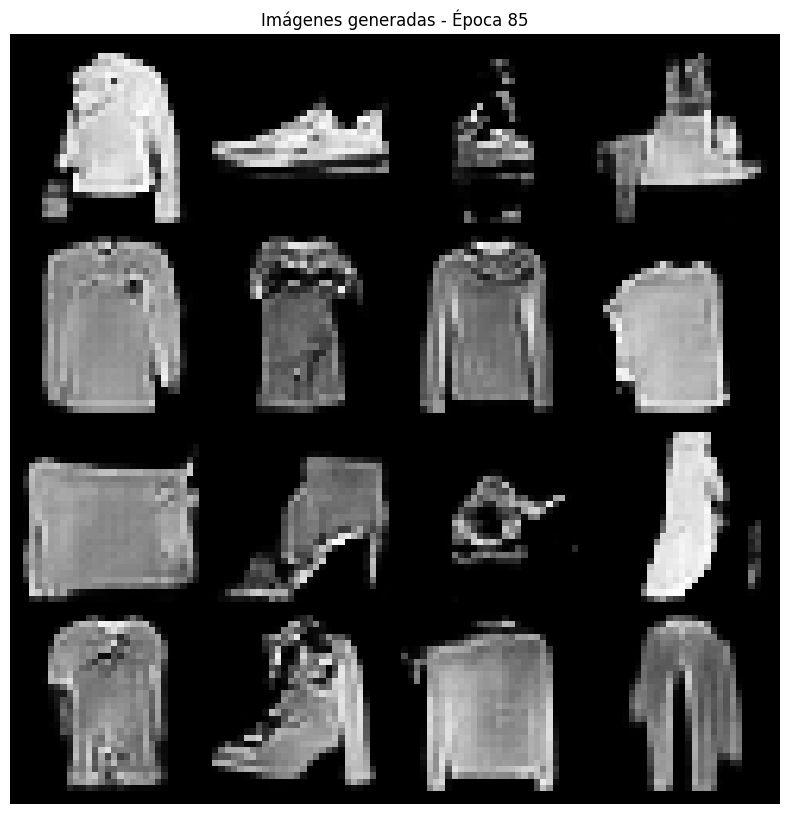

Epoch [86/200] D_loss: 0.6638, G_loss: 0.8784


Epoch [87/200] D_loss: 0.6633, G_loss: 0.8897


Epoch [88/200] D_loss: 0.6634, G_loss: 0.8857


Epoch [89/200] D_loss: 0.6629, G_loss: 0.8815


Epoch [90/200] D_loss: 0.6638, G_loss: 0.8810


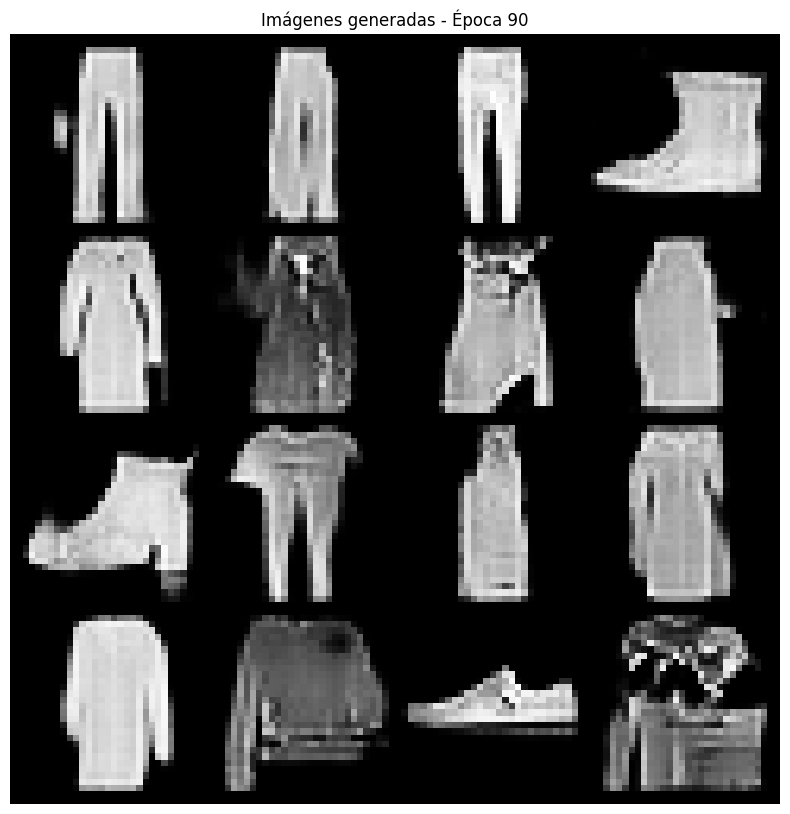

Epoch [91/200] D_loss: 0.6638, G_loss: 0.8795


Epoch [92/200] D_loss: 0.6649, G_loss: 0.8813


Epoch [93/200] D_loss: 0.6659, G_loss: 0.8734


Epoch [94/200] D_loss: 0.6637, G_loss: 0.8773


Epoch [95/200] D_loss: 0.6642, G_loss: 0.8835


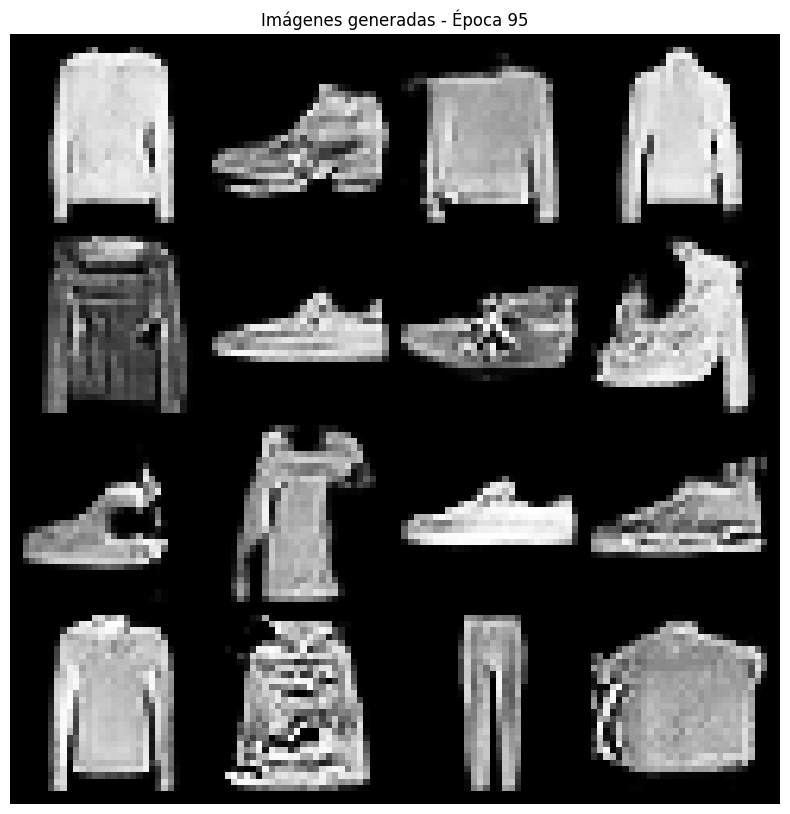

Epoch [96/200] D_loss: 0.6649, G_loss: 0.8770


Epoch [97/200] D_loss: 0.6655, G_loss: 0.8738


Epoch [98/200] D_loss: 0.6655, G_loss: 0.8728


Epoch [99/200] D_loss: 0.6653, G_loss: 0.8740


Epoch [100/200] D_loss: 0.6668, G_loss: 0.8709


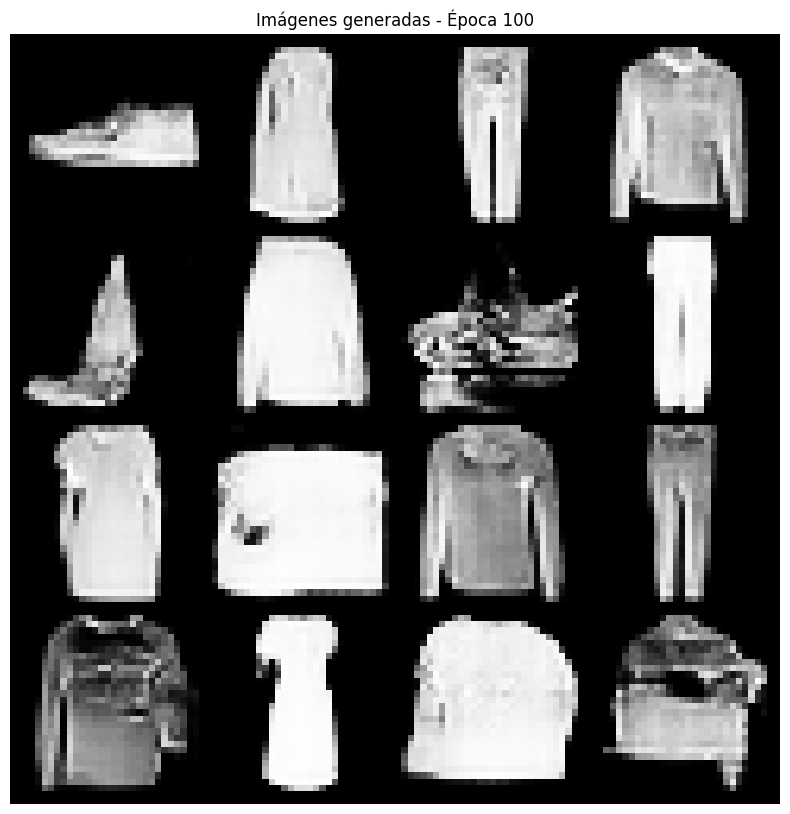

Epoch [101/200] D_loss: 0.6660, G_loss: 0.8824


Epoch [102/200] D_loss: 0.6653, G_loss: 0.8719


Epoch [103/200] D_loss: 0.6646, G_loss: 0.8728


Epoch [104/200] D_loss: 0.6683, G_loss: 0.8694


Epoch [105/200] D_loss: 0.6672, G_loss: 0.8670


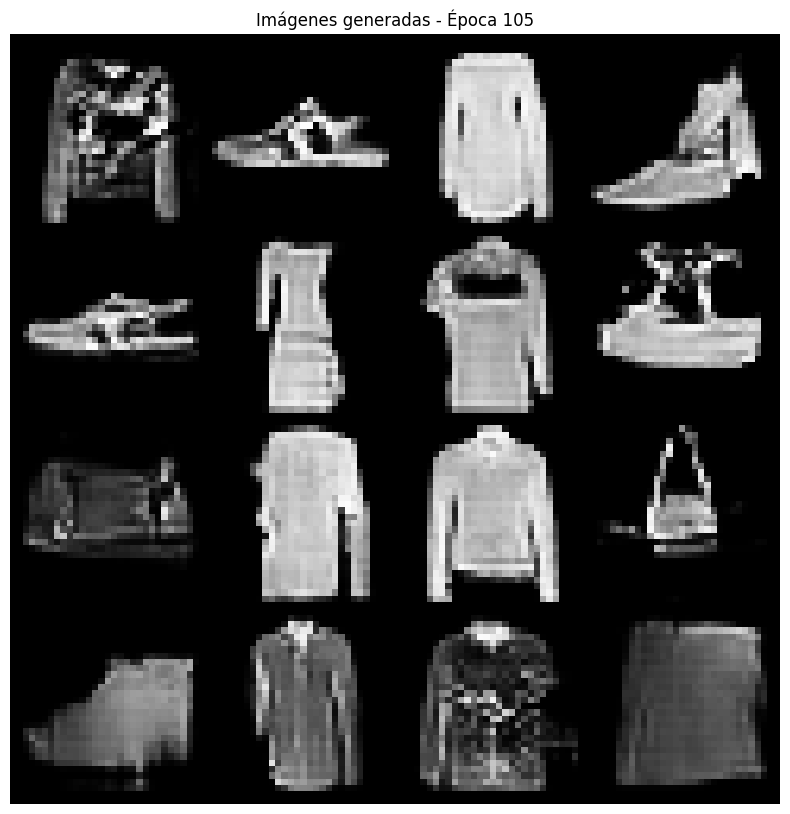

Epoch [106/200] D_loss: 0.6653, G_loss: 0.8715


Epoch [107/200] D_loss: 0.6675, G_loss: 0.8720


Epoch [108/200] D_loss: 0.6682, G_loss: 0.8752


Epoch [109/200] D_loss: 0.6666, G_loss: 0.8678


Epoch [110/200] D_loss: 0.6673, G_loss: 0.8657


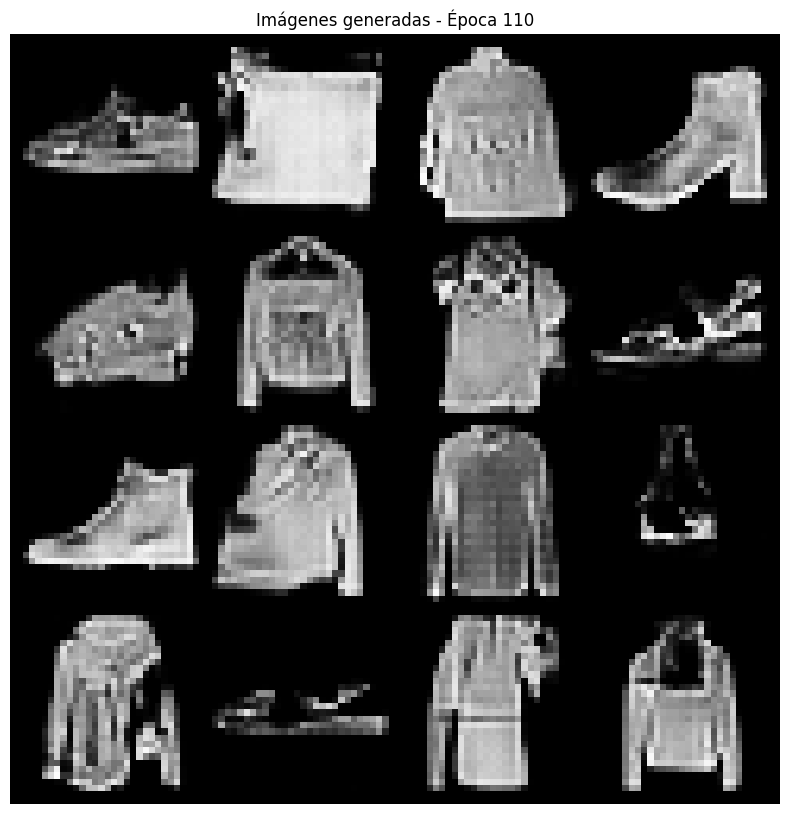

Epoch [111/200] D_loss: 0.6674, G_loss: 0.8693


Epoch [112/200] D_loss: 0.6683, G_loss: 0.8593


Epoch [113/200] D_loss: 0.6674, G_loss: 0.8633


Epoch [114/200] D_loss: 0.6663, G_loss: 0.8764


Epoch [115/200] D_loss: 0.6695, G_loss: 0.8649


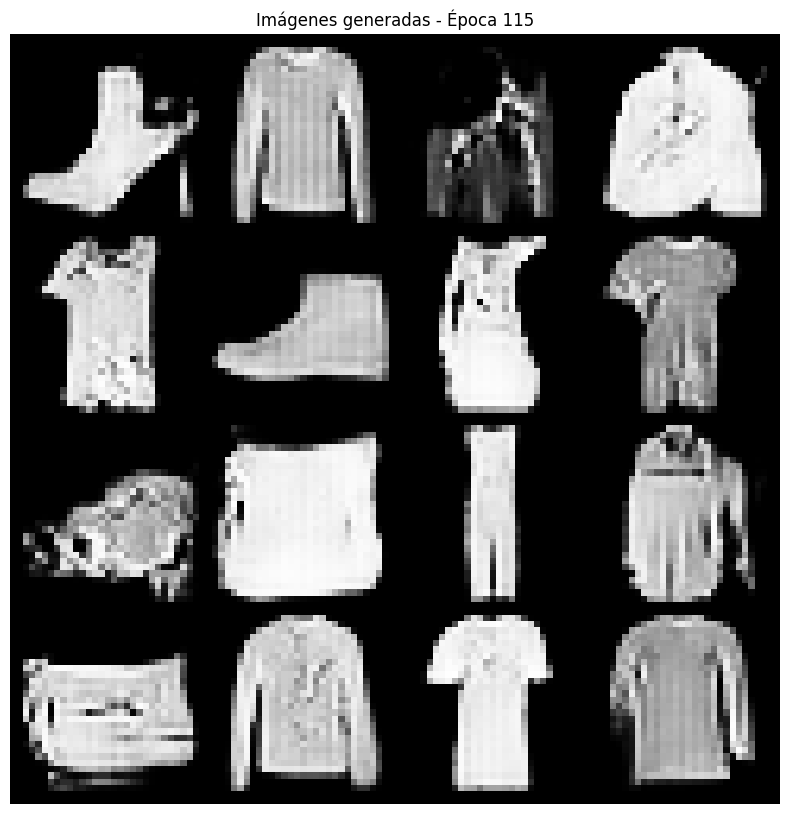

Epoch [116/200] D_loss: 0.6681, G_loss: 0.8570


Epoch [117/200] D_loss: 0.6700, G_loss: 0.8583


Epoch [118/200] D_loss: 0.6685, G_loss: 0.8661


Epoch [119/200] D_loss: 0.6677, G_loss: 0.8705


Epoch [120/200] D_loss: 0.6685, G_loss: 0.8629


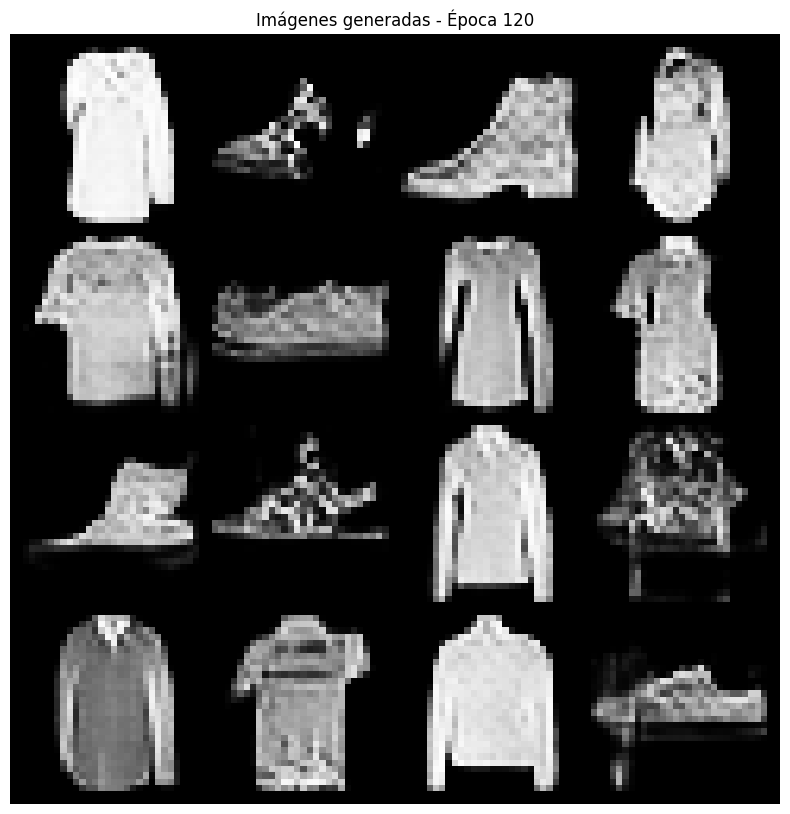

Epoch [121/200] D_loss: 0.6706, G_loss: 0.8653


Epoch [122/200] D_loss: 0.6698, G_loss: 0.8560


Epoch [123/200] D_loss: 0.6683, G_loss: 0.8608


Epoch [124/200] D_loss: 0.6687, G_loss: 0.8593


Epoch [125/200] D_loss: 0.6691, G_loss: 0.8637


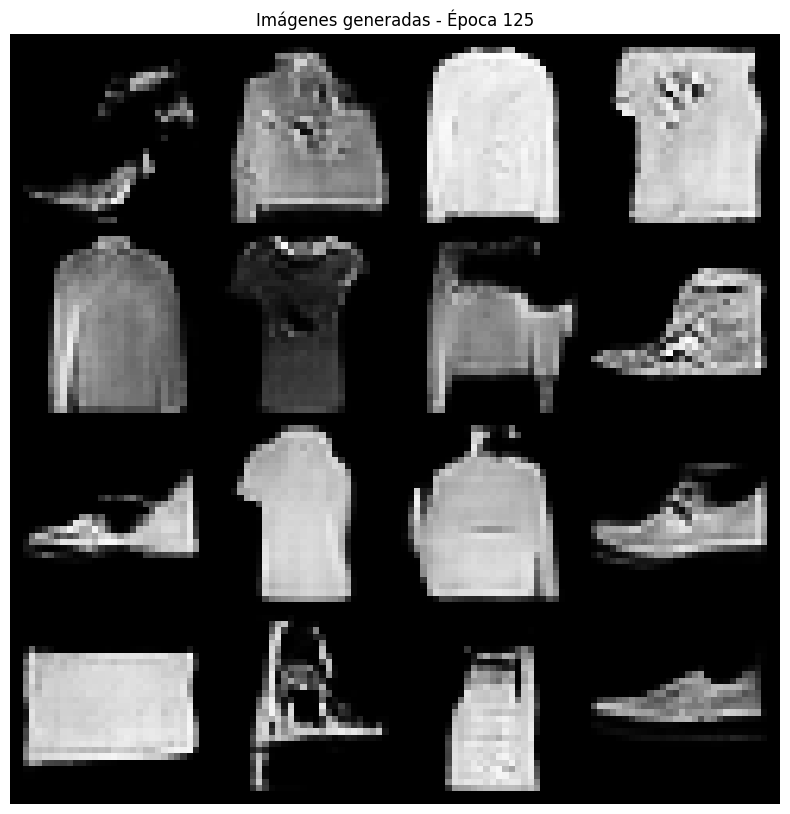

Epoch [126/200] D_loss: 0.6692, G_loss: 0.8623


Epoch [127/200] D_loss: 0.6697, G_loss: 0.8577


Epoch [128/200] D_loss: 0.6701, G_loss: 0.8551


Epoch [129/200] D_loss: 0.6696, G_loss: 0.8686


Epoch [130/200] D_loss: 0.6691, G_loss: 0.8553


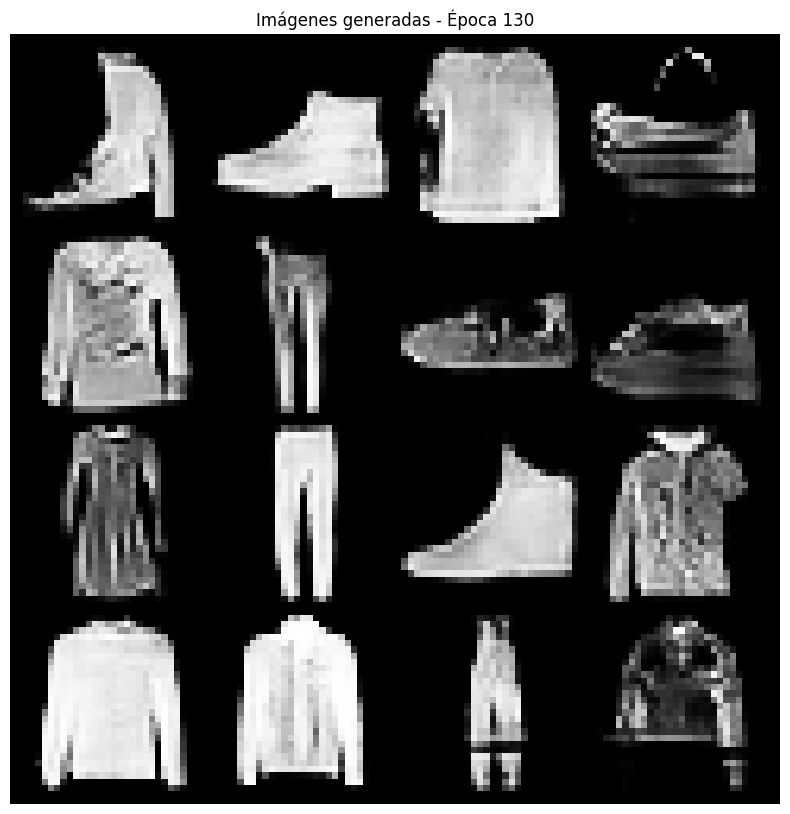

Epoch [131/200] D_loss: 0.6714, G_loss: 0.8564


Epoch [132/200] D_loss: 0.6728, G_loss: 0.8581


Epoch [133/200] D_loss: 0.6692, G_loss: 0.8554


Epoch [134/200] D_loss: 0.6718, G_loss: 0.8526


Epoch [135/200] D_loss: 0.6701, G_loss: 0.8574


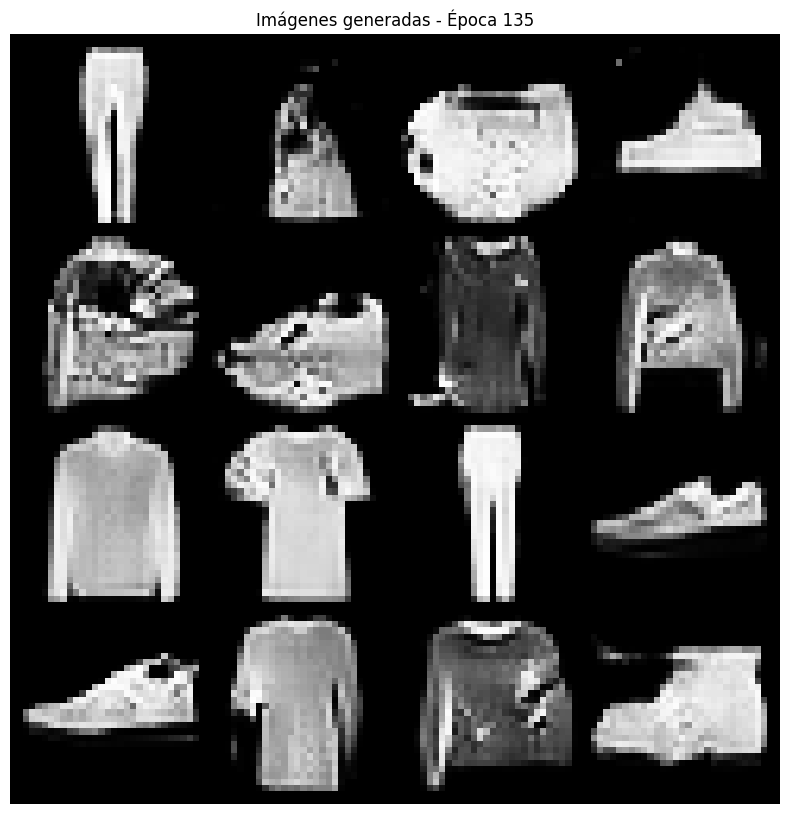

Epoch [136/200] D_loss: 0.6700, G_loss: 0.8539


Epoch [137/200] D_loss: 0.6709, G_loss: 0.8608


Epoch [138/200] D_loss: 0.6710, G_loss: 0.8569


Epoch [139/200] D_loss: 0.6713, G_loss: 0.8512


Epoch [140/200] D_loss: 0.6703, G_loss: 0.8484


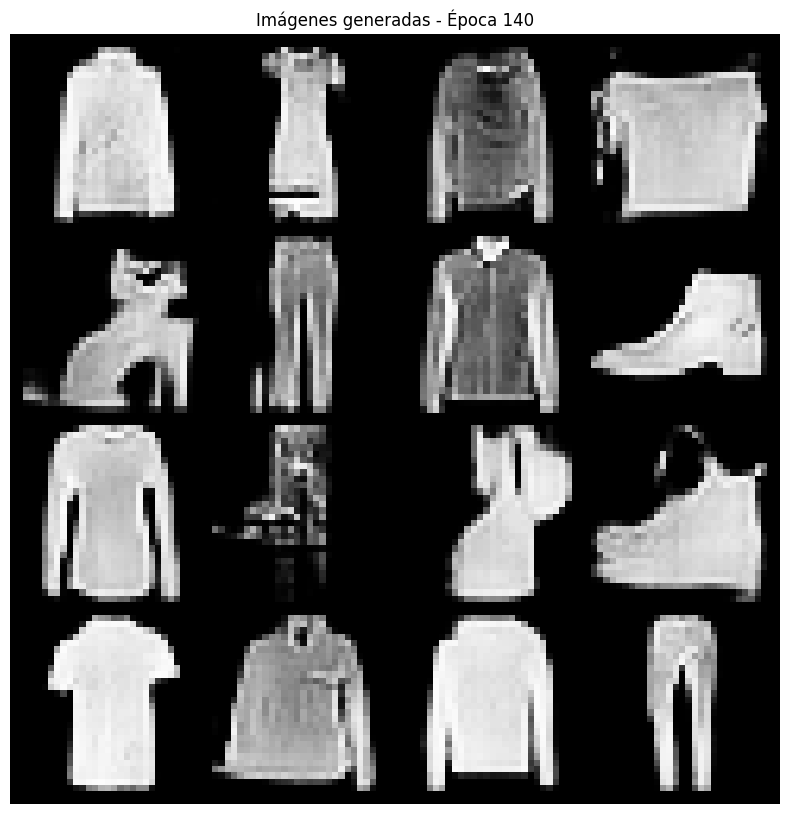

Epoch [141/200] D_loss: 0.6710, G_loss: 0.8501


Epoch [142/200] D_loss: 0.6717, G_loss: 0.8596


Epoch [143/200] D_loss: 0.6716, G_loss: 0.8529


Epoch [144/200] D_loss: 0.6713, G_loss: 0.8498


Epoch [145/200] D_loss: 0.6716, G_loss: 0.8460


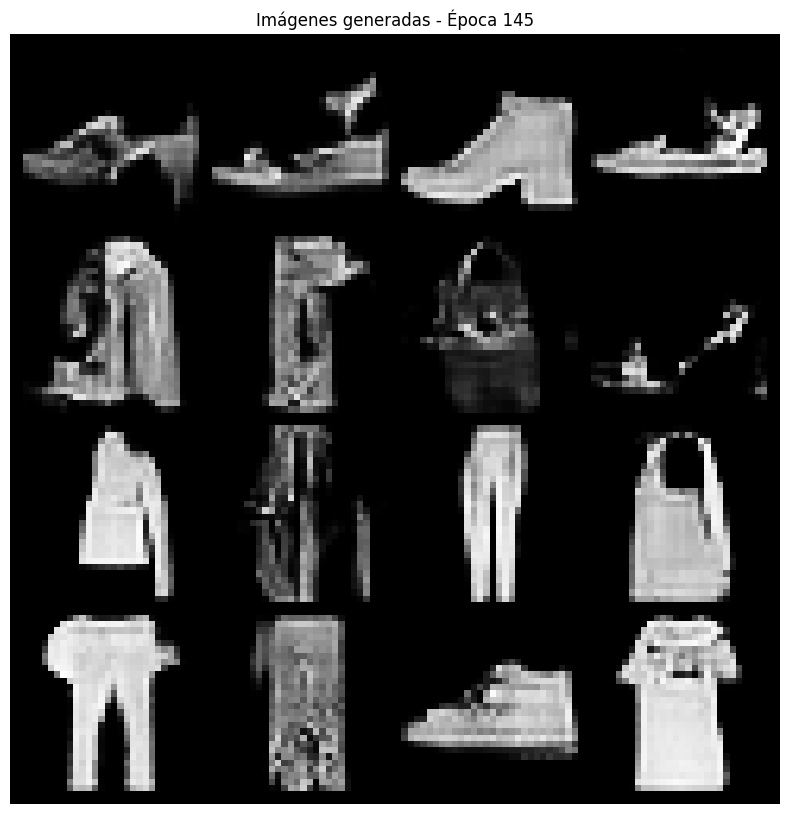

Epoch [146/200] D_loss: 0.6720, G_loss: 0.8541


Epoch [147/200] D_loss: 0.6724, G_loss: 0.8489


Epoch [148/200] D_loss: 0.6713, G_loss: 0.8455


Epoch [149/200] D_loss: 0.6716, G_loss: 0.8512


Epoch [150/200] D_loss: 0.6709, G_loss: 0.8569


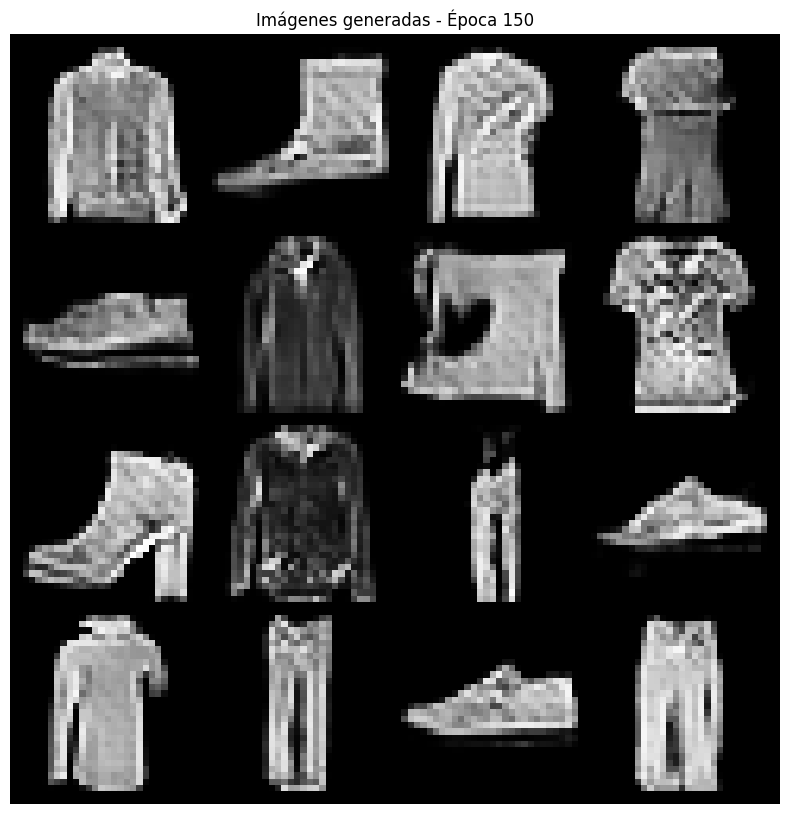

Epoch [151/200] D_loss: 0.6711, G_loss: 0.8554


Epoch [152/200] D_loss: 0.6718, G_loss: 0.8454


Epoch [153/200] D_loss: 0.6732, G_loss: 0.8503


Epoch [154/200] D_loss: 0.6719, G_loss: 0.8470


Epoch [155/200] D_loss: 0.6726, G_loss: 0.8419


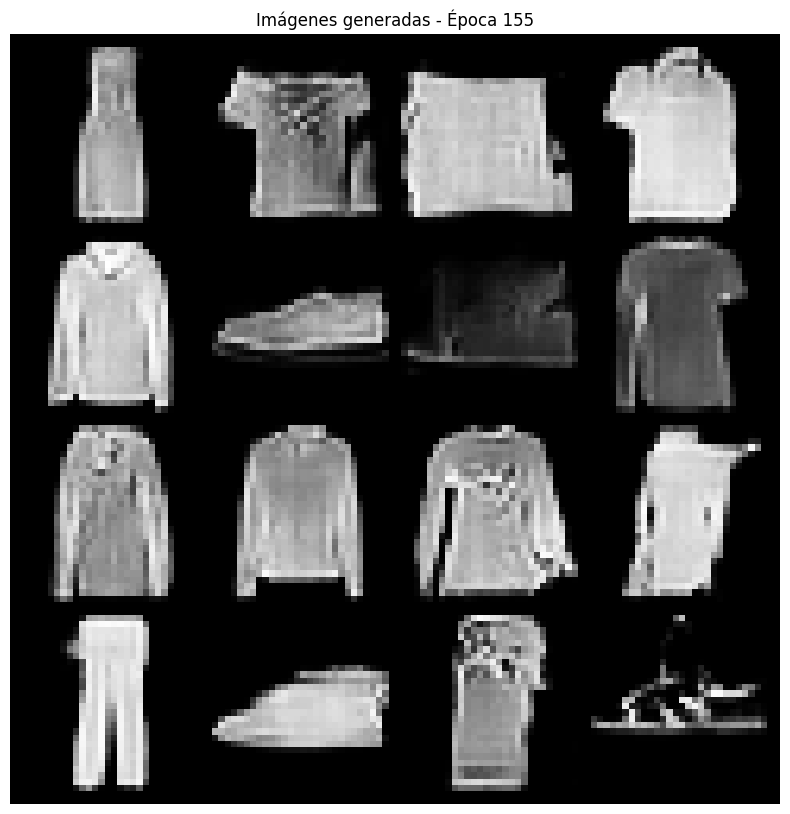

Epoch [156/200] D_loss: 0.6716, G_loss: 0.8464


Epoch [157/200] D_loss: 0.6712, G_loss: 0.8520


Epoch [158/200] D_loss: 0.6724, G_loss: 0.8537


Epoch [159/200] D_loss: 0.6729, G_loss: 0.8548


Epoch [160/200] D_loss: 0.6713, G_loss: 0.8459


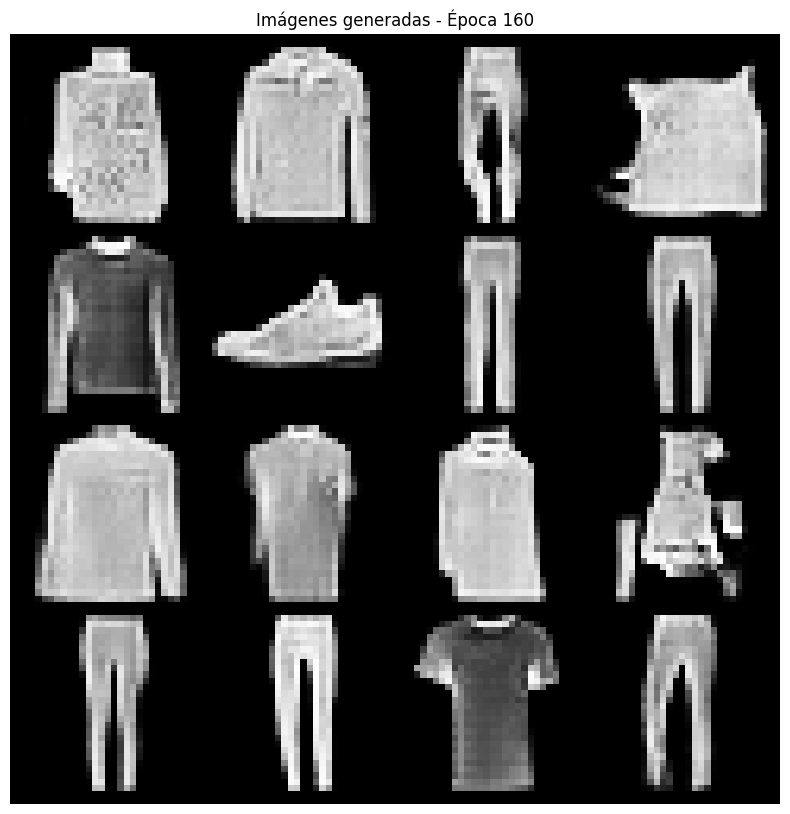

Epoch [161/200] D_loss: 0.6720, G_loss: 0.8450


Epoch [162/200] D_loss: 0.6713, G_loss: 0.8502


Epoch [163/200] D_loss: 0.6736, G_loss: 0.8489


Epoch [164/200] D_loss: 0.6731, G_loss: 0.8474


Epoch [165/200] D_loss: 0.6730, G_loss: 0.8514


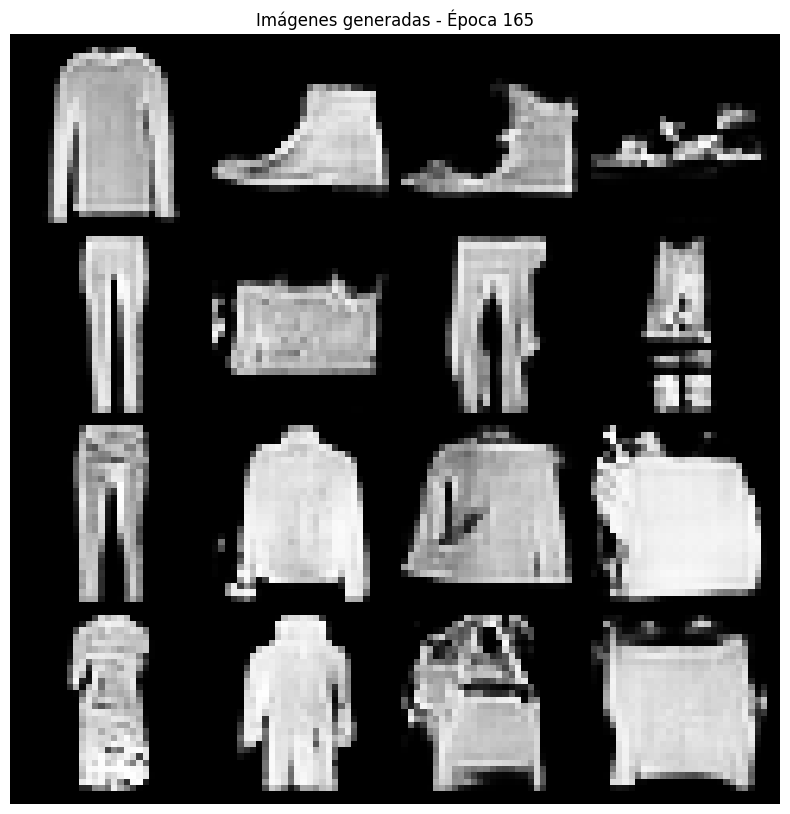

Epoch [166/200] D_loss: 0.6734, G_loss: 0.8440


Epoch [167/200] D_loss: 0.6733, G_loss: 0.8416


Epoch [168/200] D_loss: 0.6737, G_loss: 0.8422


Epoch [169/200] D_loss: 0.6721, G_loss: 0.8698


Epoch [170/200] D_loss: 0.6726, G_loss: 0.8466


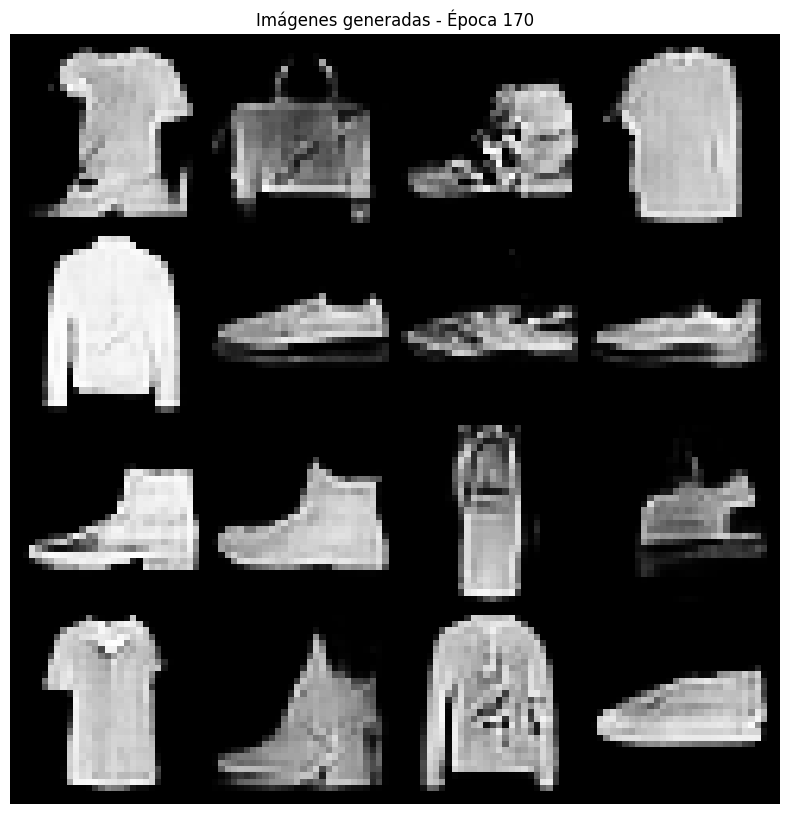

Epoch [171/200] D_loss: 0.6740, G_loss: 0.8387


Epoch [172/200] D_loss: 0.6733, G_loss: 0.8420


Epoch [173/200] D_loss: 0.6744, G_loss: 0.8407


Epoch [174/200] D_loss: 0.6731, G_loss: 0.8437


Epoch [175/200] D_loss: 0.6738, G_loss: 0.8458


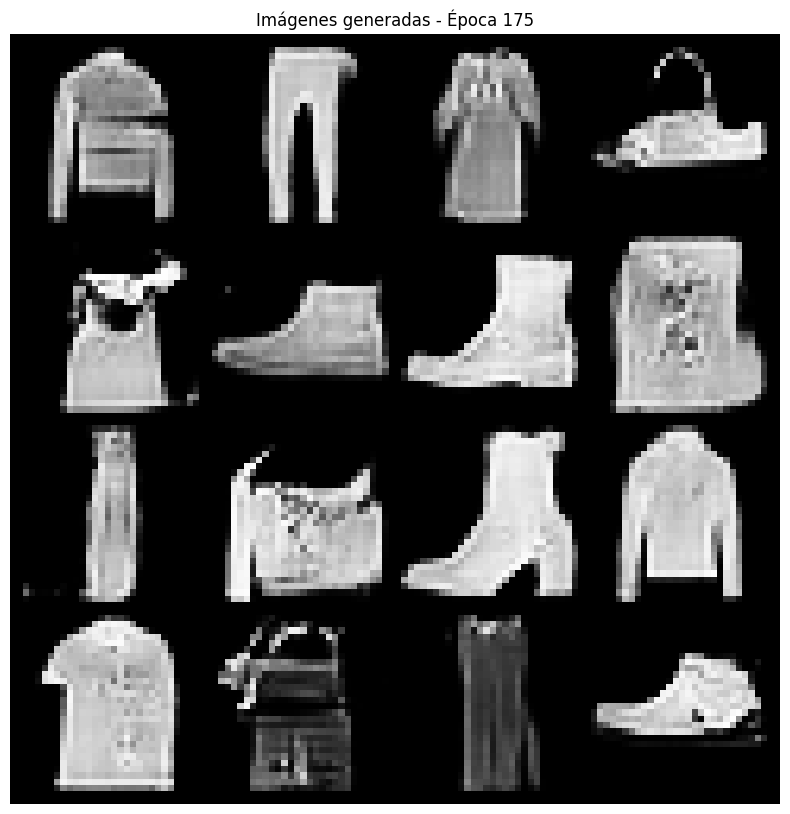

Epoch [176/200] D_loss: 0.6738, G_loss: 0.8452


Epoch [177/200] D_loss: 0.6737, G_loss: 0.8423


Epoch [178/200] D_loss: 0.6735, G_loss: 0.8439


Epoch [179/200] D_loss: 0.6744, G_loss: 0.8500


Epoch [180/200] D_loss: 0.6750, G_loss: 0.8403


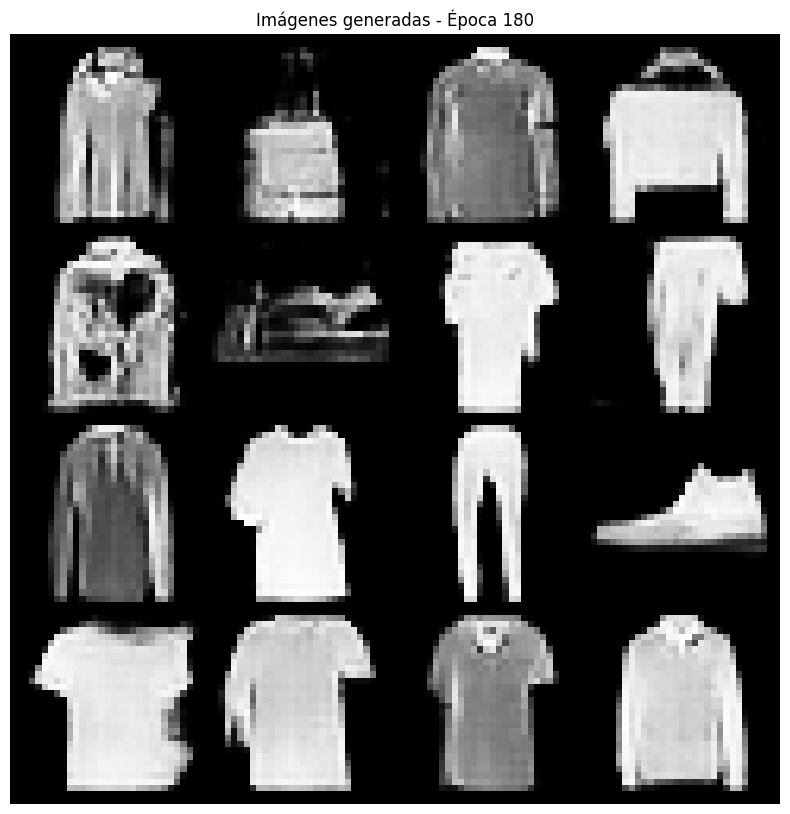

Epoch [181/200] D_loss: 0.6735, G_loss: 0.8400


Epoch [182/200] D_loss: 0.6741, G_loss: 0.8400


Epoch [183/200] D_loss: 0.6742, G_loss: 0.8436


Epoch [184/200] D_loss: 0.6749, G_loss: 0.8383


Epoch [185/200] D_loss: 0.6752, G_loss: 0.8350


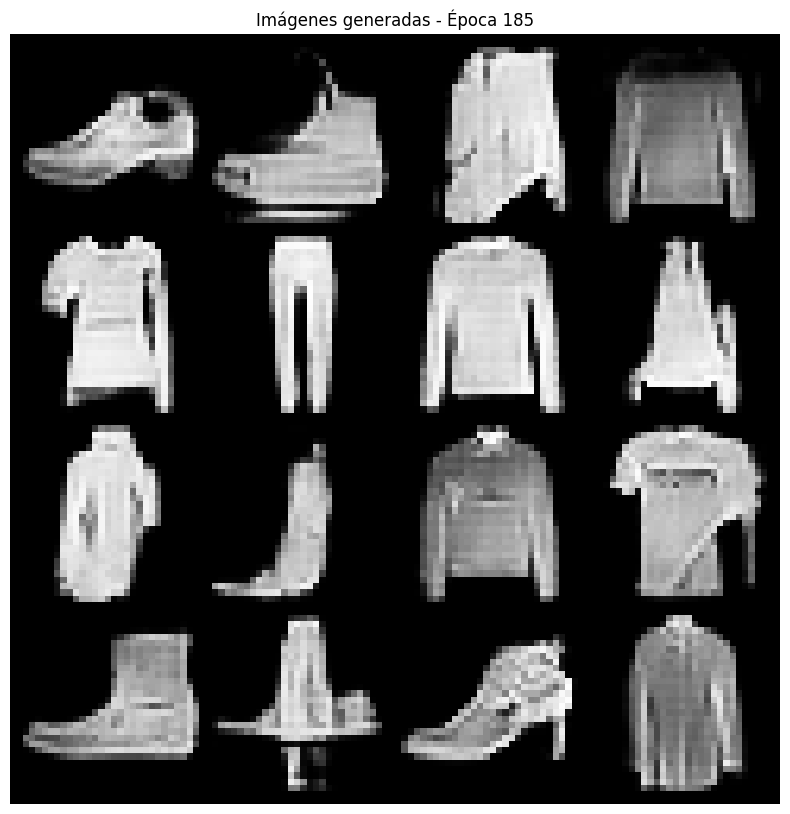

Epoch [186/200] D_loss: 0.6745, G_loss: 0.8422


Epoch [187/200] D_loss: 0.6746, G_loss: 0.8412


Epoch [188/200] D_loss: 0.6761, G_loss: 0.8368


Epoch [189/200] D_loss: 0.6755, G_loss: 0.8366


Epoch [190/200] D_loss: 0.6756, G_loss: 0.8390


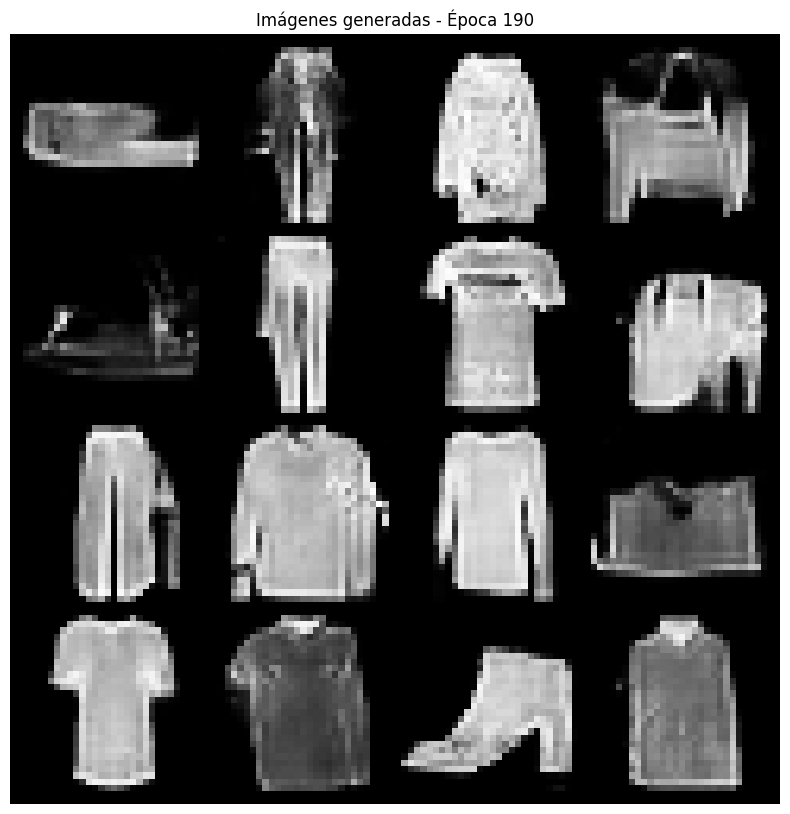

Epoch [191/200] D_loss: 0.6746, G_loss: 0.8382


Epoch [192/200] D_loss: 0.6748, G_loss: 0.8384


Epoch [193/200] D_loss: 0.6747, G_loss: 0.8417


Epoch [194/200] D_loss: 0.6748, G_loss: 0.8397


Epoch [195/200] D_loss: 0.6750, G_loss: 0.8388


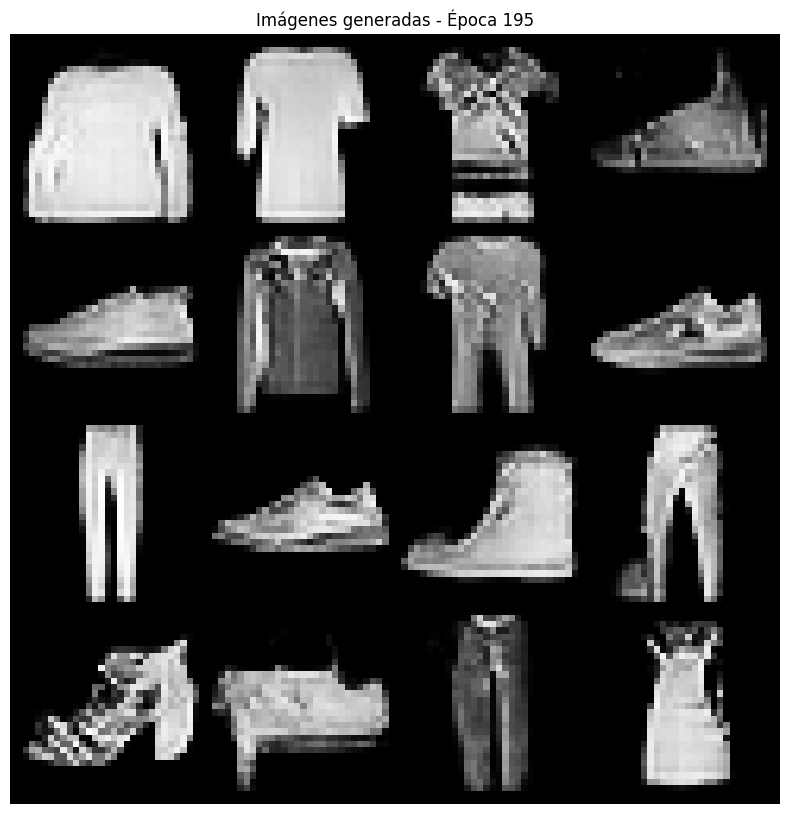

Epoch [196/200] D_loss: 0.6761, G_loss: 0.8356


Epoch [197/200] D_loss: 0.6750, G_loss: 0.8432


Epoch [198/200] D_loss: 0.6748, G_loss: 0.8440


Epoch [199/200] D_loss: 0.6756, G_loss: 0.8396


Epoch [200/200] D_loss: 0.6763, G_loss: 0.8411


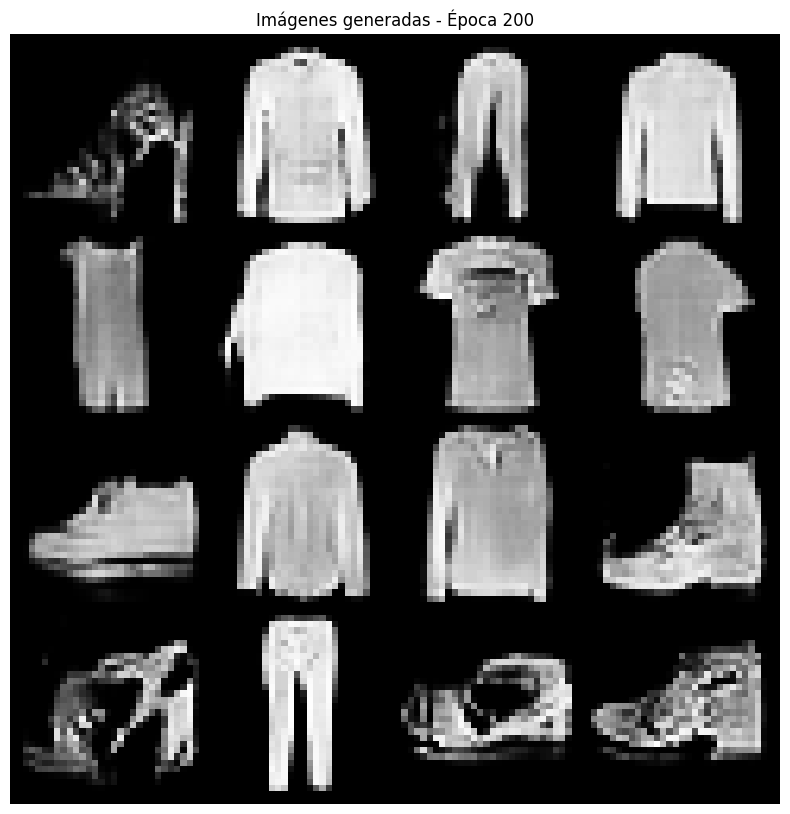

In [17]:
from tqdm import tqdm  # Librería tqdm para mostrar barras de progreso
import os

# Ponemos ambos modelos en modo entrenamiento
generator.train()
discriminator.train()

# Entrenamiento de la GAN
# Entrenamiento de la GAN
for epoch in range(EPOCHS):
    epoch_disc_loss = 0
    epoch_gen_loss = 0

    for real_images, _ in tqdm(trainloader, desc=f"Epoch {epoch + 1}", leave=False):
        # Mover las imágenes a GPU si está disponible
        real_images = real_images.to(device)
        current_batch_size = real_images.size(0)

        # Crear etiquetas con ruido para mejorar la estabilidad
        real_labels = torch.ones(current_batch_size, 1, device=device) * 0.9  # Label smoothing
        fake_labels = torch.zeros(current_batch_size, 1, device=device)

        # -------- Entrenamiento del discriminador --------
        disc_optimizer.zero_grad()  # Mover aquí para mejor claridad

        # Generar imágenes falsas
        noise = torch.randn(current_batch_size, LATENT_DIM, device=device)
        with torch.no_grad():  # No necesitamos gradientes aquí
            generated_images = generator(noise)

        # Pérdida del discriminador con imágenes reales
        real_output = discriminator(real_images)
        real_loss = criterion(real_output, real_labels)

        # Pérdida del discriminador con imágenes falsas
        fake_output = discriminator(generated_images)
        fake_loss = criterion(fake_output, fake_labels)

        # Pérdida total del discriminador
        disc_loss = (real_loss + fake_loss) / 2  # Promedio para mejor estabilidad
        disc_loss.backward()
        disc_optimizer.step()

        epoch_disc_loss += disc_loss.item()

        # -------- Entrenamiento del generador --------
        gen_optimizer.zero_grad()

        # Generar nuevas imágenes falsas
        noise = torch.randn(current_batch_size, LATENT_DIM, device=device)
        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        
        # Calcular pérdida del generador
        gen_loss = criterion(fake_output, real_labels)
        gen_loss.backward()
        gen_optimizer.step()

        epoch_gen_loss += gen_loss.item()

    # Calcular pérdidas promedio
    avg_disc_loss = epoch_disc_loss / len(trainloader)
    avg_gen_loss = epoch_gen_loss / len(trainloader)

    print(f"Epoch [{epoch + 1}/{EPOCHS}] "
          f"D_loss: {avg_disc_loss:.4f}, G_loss: {avg_gen_loss:.4f}")
    
    # Crear la carpeta 'images' si no existe
    if not os.path.exists('images'):
        os.makedirs('images')
    
    # Mostrar algunas imágenes generadas cada N épocas
    if (epoch + 1) % 5 == 0:
        generator.eval()
        with torch.no_grad():
            sample_noise = torch.randn(16, LATENT_DIM, device=device)
            fake_images = generator(sample_noise)
            
            # Crear una figura con subplots
            plt.figure(figsize=(10, 10))
            plt.title(f"Imágenes generadas - Época {epoch+1}")
            
            # Crear grid de imágenes
            grid = vutils.make_grid(
                fake_images.cpu(),
                padding=2,
                normalize=True,
                nrow=4
            )
            
            # Mostrar el grid
            plt.imshow(grid.permute(1, 2, 0).numpy(), cmap='gray')
            plt.axis('off')
            plt.show()
            
            # Guardar algunas imágenes generadas cada N épocas
            save_images(fake_images, f"epoch_{epoch+1}")

        generator.train()
        
    # Crear la carpeta 'models' si no existe
    if not os.path.exists('models'):
        os.makedirs('models')

    # Cada 10 épocas guardamos el modelo
    if (epoch + 1) % 10 == 0:
        torch.save(generator.state_dict(), f'models/generator_{epoch + 1}.pth')
        torch.save(discriminator.state_dict(), f'models/discriminator_{epoch + 1}.pth')

# Guardamos el modelo
torch.save(generator.state_dict(), 'models/generator.pth')

In [18]:
# Hacemos un gif con las imagenes generadas
import imageio.v2 as imageio
import os

# Directorio con las imágenes generadas
images_dir = 'images'

# Lista de imágenes generadas
images = [img for img in os.listdir(images_dir) if img.endswith(".png")]

# Ordenamos las imágenes por el número de época
images.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Creamos el gif
images_gif = []
for img in images:
    images_gif.append(imageio.imread(os.path.join(images_dir, img)))
    
# Guardamos el gif
imageio.mimsave('images/generated_images.gif', images_gif, fps=2, loop=0)

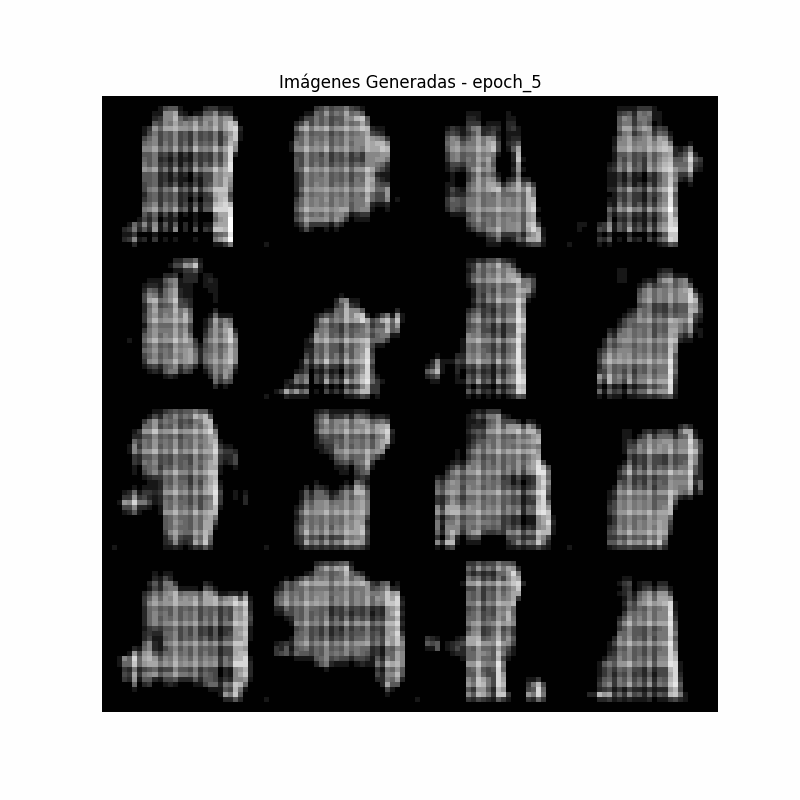

In [19]:
from IPython.display import Image

# Ruta del GIF generado
gif_path = 'images/generated_images.gif'

# Mostrar el GIF
Image(filename=gif_path)